# 1. Function part

## 1.1 environment

In [1]:
import os
import re
import math
import lmdb
import torch
import random
import pickle
import shutil
import itertools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as sp_distance

from ase.atoms import Atoms
from vaspvis import standard
from ase.build import add_vacuum
from ase.calculators.emt import EMT
from ase.optimize import LBFGS, BFGS
from spektral.data import Dataset, Graph
from ase.visualize.plot import plot_atoms
from ase.io import write, read, lammpsdata
from ocpmodels.datasets import LmdbDataset
from ocpmodels.preprocessing import AtomsToGraphs
from ase.constraints import FixAtoms, FixCartesian
from ase.build import add_adsorbate, molecule, fcc111

2023-11-29 22:07:47.414509: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 22:07:47.439327: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 22:07:47.439350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 22:07:47.439365: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 22:07:47.443791: I tensorflow/core/platform/cpu_feature_g

## 1.2 Function

In [2]:
from ocpre import *  # 本项目相关的基础函数写在ocpre中

In [3]:
def set_cons0(model):
    """
    此约束的效果是：固定表面两层以下的原子
    """
    slab = model.copy()
    layers = sort_z(slab.get_positions()[:, 2])
    tags = np.zeros(len(slab))

    filtered_layers2 = [i for i in range(len(layers)) if layers[i] > max(layers) - 2]  #
    tags[filtered_layers2] = 1  # 被吸附基底的次表面和表面

    filtered_layers1 = [i for i in range(len(layers)) if layers[i] > max(layers) - 1]  #
    tags[filtered_layers1] = 2  # 被吸附基底的表面层

    slab.set_tags(tags)  # 将tags属性替换
    # Fixed atoms are prevented from moving during a structure relaxation. We fix all slab atoms beneath the surface
    cons0 = FixAtoms(indices=[atom.index for atom in slab if (atom.tag < 1)])
    cons1 = FixCartesian(filtered_layers2, mask=(1, 1, 0))
    slab.set_constraint([cons0, cons1])
    slab.set_pbc(True)
    return slab


def set_cons1(model):
    """
    此约束的效果是：固定表面一层以下 和 左下角 的原子
    """
    f_pos = model.get_scaled_positions()
    slab = model.copy()
    layers = sort_z(slab.get_positions()[:, 2])
    tags = np.zeros(len(slab))

    filtered_layers2 = [i for i in range(len(layers)) if layers[i] > max(layers) - 2]  #
    tags[filtered_layers2] = 1  # 被吸附基底的次表面和表面

    filtered_layers1 = [i for i in range(len(layers)) if layers[i] > max(layers) - 1]  #
    tags[filtered_layers1] = 2  # 被吸附基底的表面层

    filtered_layers0 = [
        i for i in range(len(model)) if tags[i] == 2 and f_pos[i, 0] + f_pos[i, 1] < 0.5
    ]  #
    tags[filtered_layers0] = -1  # 左下角的三个原子

    slab.set_tags(tags)  # 将tags属性替换
    # Fixed atoms are prevented from moving during a structure relaxation. We fix all slab atoms beneath the surface
    cons0 = FixAtoms(indices=[atom.index for atom in slab if (atom.tag < 2)])
    # cons1 = FixCartesian(filtered_layers2,mask=(1, 1, 0))
    slab.set_constraint([cons0])
    slab.set_pbc(True)
    return slab


def set_cons2(model):
    """
    此约束的效果是：固定所有Cu原子，而氧原子固定x和y方向
    """

    slab = model.copy()
    # Fixed atoms are prevented from moving during a structure relaxation. We fix all slab atoms beneath the surface
    atomic_numbers = slab.get_atomic_numbers()
    cons0 = FixAtoms(
        indices=[slab[i].index for i in range(len(slab)) if atomic_numbers[i] != 8]
    )
    filtered_layers1 = [
        i for i in range(len(atomic_numbers)) if atomic_numbers[i] == 8
    ]  #
    cons1 = FixCartesian(filtered_layers1, mask=(1, 1, 0))
    slab.set_constraint([cons0, cons1])
    slab.set_pbc(True)
    return slab


def set_cons3(model):
    """
    此约束的效果是：固定表面一层以下 和 左下角 的原子，而氧原子固定x和y方向
    """
    model1 = model.copy()
    model0 = model.copy()
    atomic_numbers = model0.get_atomic_numbers()
    filtered_layers1 = [
        i for i in range(len(atomic_numbers)) if atomic_numbers[i] == 8
    ]  #
    del model0[filtered_layers1]  # 先暂时删除氧原子

    model0 = set_cons1(model0)
    cons0 = model0.constraints[0]
    cons1 = FixCartesian([filtered_layers1], mask=(1, 1, 0))
    model1.set_constraint([cons0, cons1])  # 在之前约束的基础上又约束了两个

    # Fixed atoms are prevented from moving during a structure relaxation. We fix all slab atoms beneath the surface
    model1.set_pbc(True)
    return model1

## 1.3 folder path

In [4]:
folder_path_all = "/media/zwbai/DATA/dft/tc/"  # 当前文件执行的文件夹，包括输出和输入文件夹
output_path = folder_path_all + "output/"
input_path = folder_path_all + "input/"
data_path = './vasp_cal/'
exist_folder(folder_path_all, is_creat=False)  # 提前创建
exist_folder(input_path, is_creat=False)  # 提前创建
exist_folder(output_path, is_creat=True)

# input
# 多以copy或者cal结尾
CONT_path = input_path + "Ex42-Cu-Bulk/"
Cu_bulk_copy = input_path + "Cu_bulk_copy/"  #
Cu_slab_copy = input_path + "Cu_slab_copy"
refer_bulk_copy = input_path + "refer_bulk_copy"
refer_slab_copy = input_path + "refer_slab_copy"
Cu_slab4_copy = input_path + "Cu_slab4_copy"
one_atom_copy = input_path + "one_atom_copy"
nostrain_molecule_copy = input_path + "nostrain_molecule_copy"
strain_adslab_copy = input_path + "strain_adslab_copy"
dos_cal = input_path + "dos_cal"

# output
Cu_bulk_path = output_path + "Cu_bulk"  #
Cu_slab_path = output_path + "Cu_slab"

refer_bulk_folder = output_path + "refer_bulk"
refer_slab_folder = output_path + "refer_slab"
Cu_slab4_folder = output_path + "Cu_slab4"
one_atom_folder = output_path + "one_atom"
nostrain_molecule_folder = output_path + "nostrain_molecule"
strain_adslab_folder = output_path + "strain_adslab"

# data
strain_value_dict = output_path + "strain_matrix_dict.pkl"
strain_value_list = output_path + "strain_matrix.npy"

lmdb_file = output_path + "CuO2_strain_tc.lmdb"
dos_data_file = output_path + "dos_data.pkl"
dos_energy_data_file = output_path + "dos_energy_data.pkl"

data_files = [strain_value_dict, strain_value_list, lmdb_file, dos_data_file,dos_energy_data_file]

folder '/media/zwbai/DATA/dft/tc/' exists
folder '/media/zwbai/DATA/dft/tc/input/' exists
folder '/media/zwbai/DATA/dft/tc/output/' exists


In [5]:
exist_folder(output_path, is_creat=True)

folder '/media/zwbai/DATA/dft/tc/output/' exists


# 2. Initial cofiguration of bulk

In [6]:
def int_bulk():
    CONT = read_one_car(CONT_path)
    if isinstance(CONT, Atoms):
        CONT_cell = CONT.get_cell()
        LC = np.array(CONT_cell)[0, 0]
    else:
        LC = 3.615  # lattice of Cu
        # LC = 3.48 # lattice of Ni
    print(LC)
    iforthogonal = False  # 是否正交
    model = fcc111("Cu", size=(1, 1, 3), a=LC, orthogonal=iforthogonal, periodic=True)
    # 注意，这里还没有增加真空层，size[2]必须是3的倍数，这样才能保证bulk在z方向的周期性
    model.set_pbc(True)  # 最早的初始构型
    strain = cal_strain(model, model)
    # cell = model.get_cell()
    bulk = model.copy()
    plot_model(bulk)
    print(LC)
    return bulk

/media/zwbai/DATA/dft/tc/input/Ex42-Cu-Bulk/CONTCAR
3.636600176352717
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


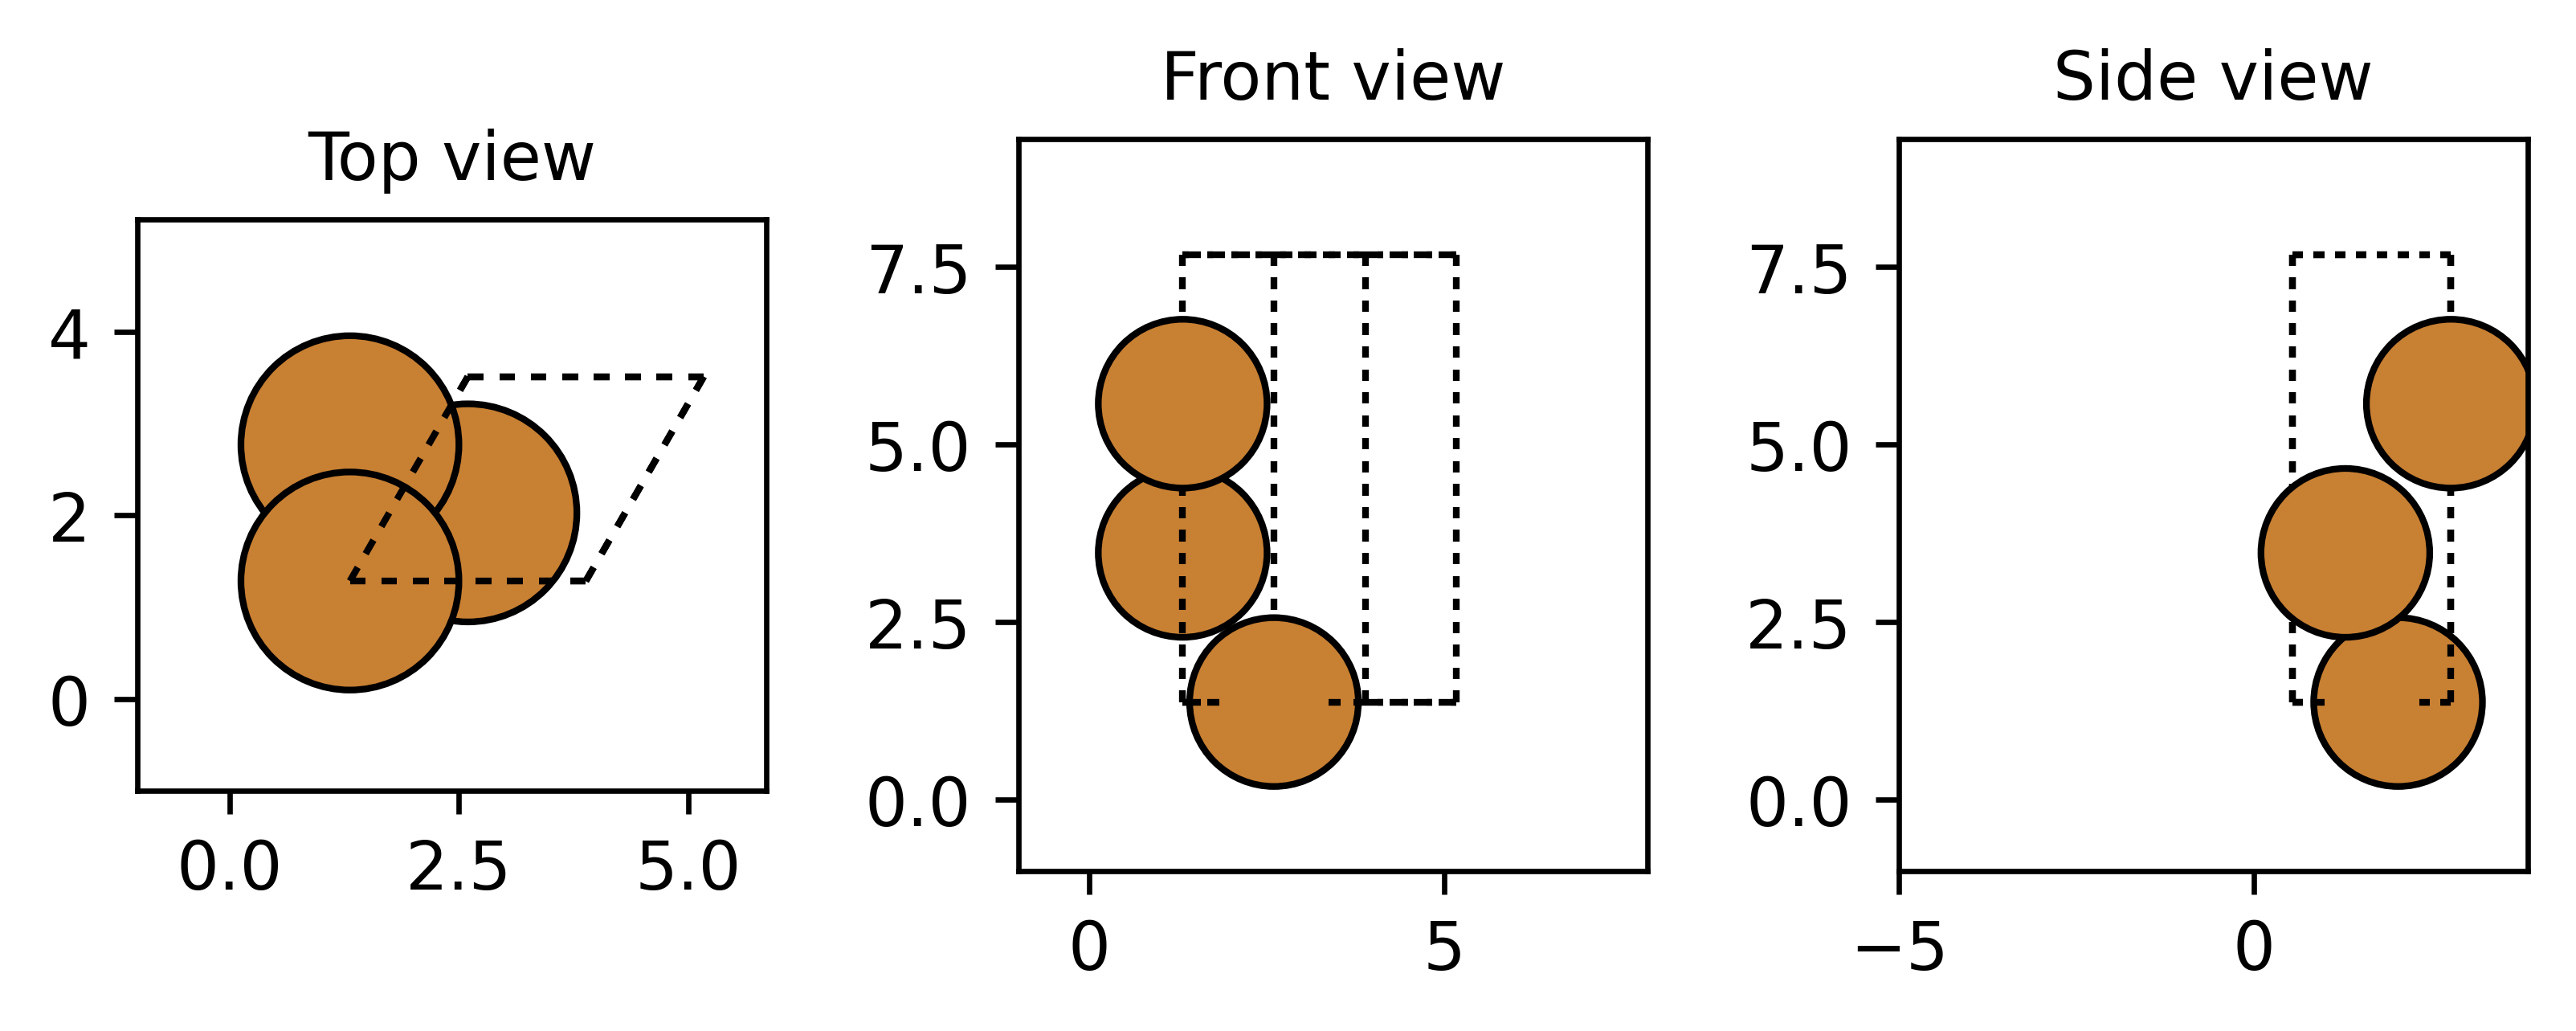

3.636600176352717
input is Atoms
Cell([[2.571464645163201, 0.0, 0.0], [1.2857323225816004, 2.226953707644869, 0.0], [0.0, 0.0, 6.2987762722568466]])
[[1.2857 0.7423 0.    ]
 [0.     1.4846 2.0996]
 [0.     0.     4.1992]]


In [7]:
bulk = int_bulk()
out_poscar(bulk, path=Cu_bulk_path)
print(bulk.get_cell())
print(bulk.get_positions())

In [8]:
bulk = read_one_car(Cu_bulk_copy)
print(bulk.get_cell())
print(bulk.get_positions())

/media/zwbai/DATA/dft/tc/input/Cu_bulk_copy/CONTCAR
Cell([[2.571464645163201, 0.0, 0.0], [1.2857323225816004, 2.226953707644869, 0.0], [0.0, 0.0, 6.309136217918443]])
[[1.2857 0.7423 0.    ]
 [2.5715 1.4846 2.103 ]
 [0.     0.     4.2061]]


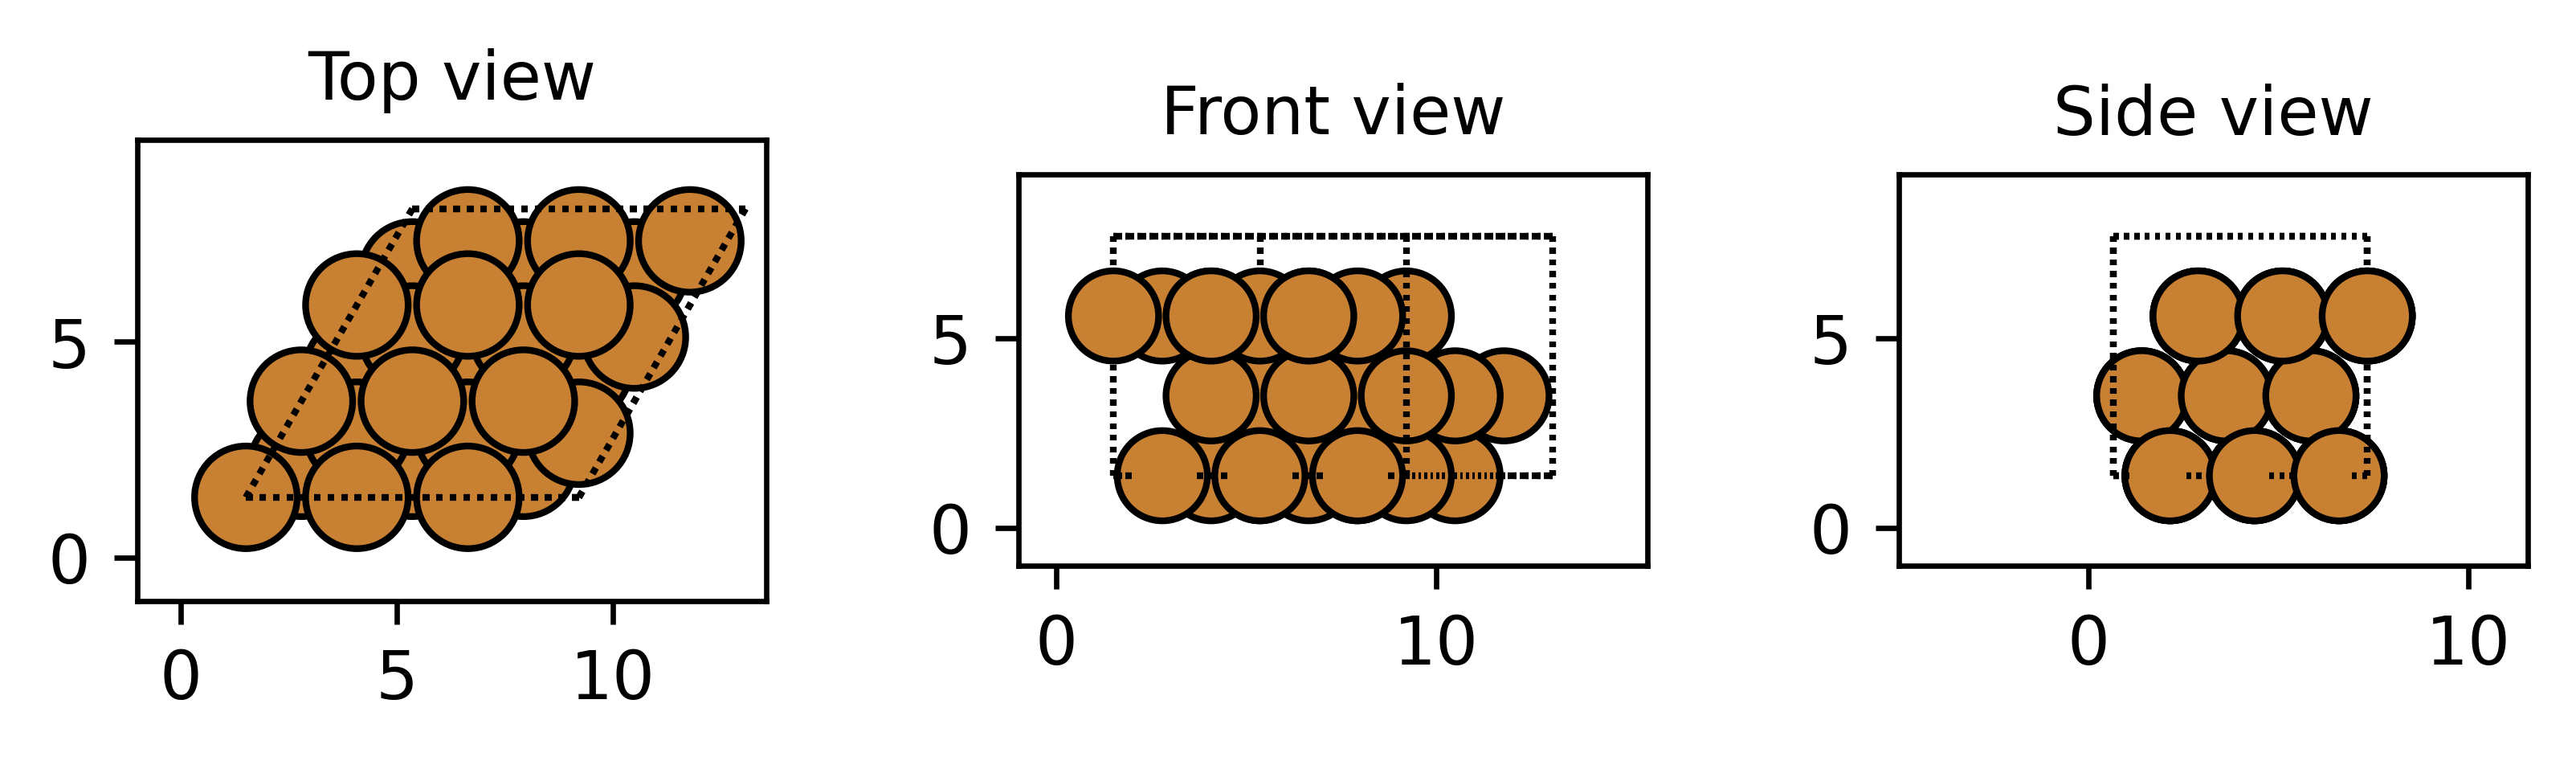

[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]


In [9]:
bulk_ex = bulk.repeat((3, 3, 1))
plot_model(bulk_ex)
print(sort_z(bulk_ex.get_positions()[:, 2]))

In [10]:
slab = vac_ext(bulk, vacuum_h=30.0, ads_layer=4)  # 多加4个原子并添加真空层
out_poscar(slab, path=Cu_slab_path)

input is Atoms
write ------ /media/zwbai/DATA/dft/tc/output/Cu_slab/POSCAR


/media/zwbai/DATA/dft/tc/input/Cu_slab_copy/CONTCAR


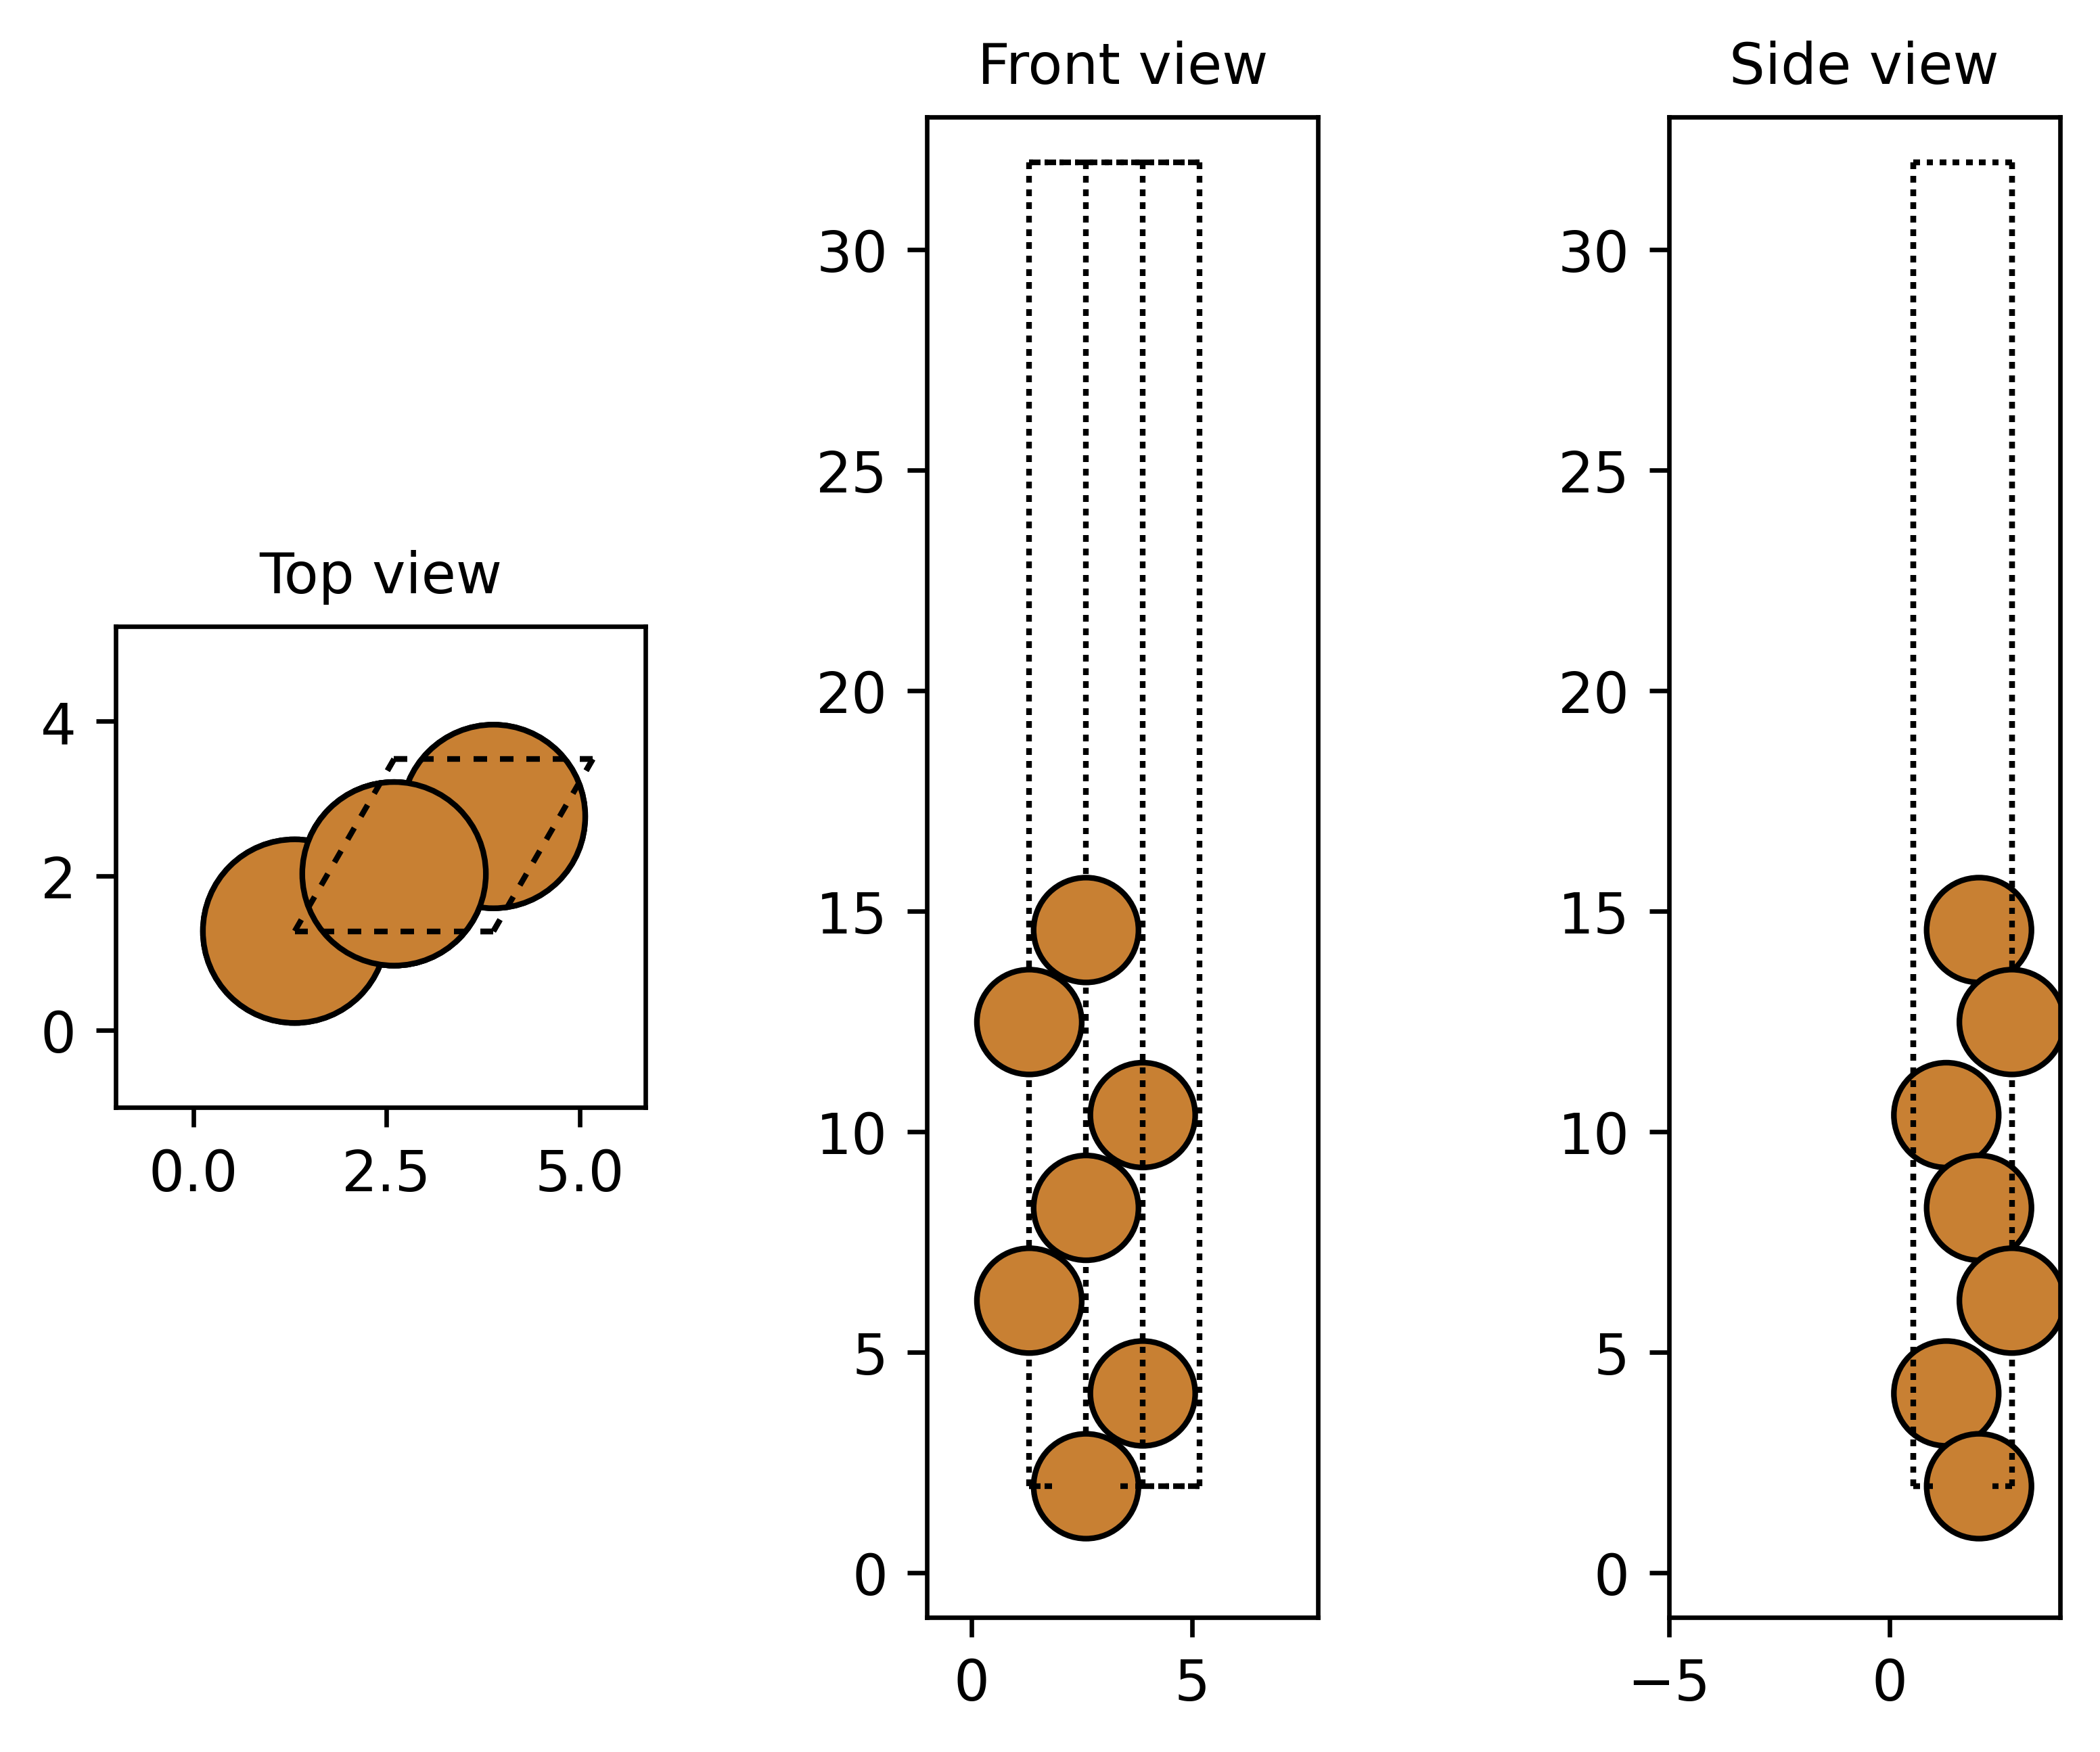

In [11]:
# 无应变的slab，优化计算结果在'./vasp_cala/Cu_slab_copy/CONTCAR'
slab_op = read_one_car(Cu_slab_copy)
plot_model(slab_op)

# 3. strain space 

## 3.1 strain value 

In [12]:
def generate_strain_matrix_shear(
    num_strain,  # 最好选择偶数
    all_model_rotate,
    strain_box,
    random_select=0,
    uniform_strain=False,
    inherit=False,
    dict_name="strain_matrix_dict.pkl",
    array_name="strain_matrix.npy",
):
    if random_select == 0:
        random_select = num_strain

    if inherit:  # load
        try:
            with open(dict_name, "rb") as file:
                strain_matrix_dict = pickle.load(file)
            strain_matrix = np.load(array_name)
            return strain_matrix, strain_matrix_dict
        except FileNotFoundError:
            print("File not found. Generating new strain matrix.")

    if uniform_strain:
        strain = poisson_disc_3d(
            strain_box, num_strain, isplot=False
        )  # generate points
        strain_matrix_dict = {-1: strain}
    else:
        print(strain_box)
        strain_box0 = strain_box.copy()
        strain_box0[0:2, 0] = 0.0
        print(strain_box0)
        print(strain_box)
        strain0 = poisson_disc_3d(
            strain_box0, math.ceil(all_model_rotate * random_select / 2), isplot=False
        )
        strain_box1 = strain_box.copy()
        strain_box1[0:2, 1] = 0.0
        strain1 = poisson_disc_3d(
            strain_box1, math.ceil(all_model_rotate * random_select / 2), isplot=False
        )
        strain = np.concatenate((strain0, strain1), axis=0)
        print(strain.shape)
    strain_matrix_dict = {}
    strain_matrix = np.zeros((all_model_rotate, random_select, 3))

    for i in range(all_model_rotate):
        if uniform_strain:
            random_numbers = random.sample(range(num_strain), random_select)
            random_numbers.sort()
        else:
            random_numbers = np.array(range(i * random_select, (i + 1) * random_select))
        for j in range(len(random_numbers)):
            key = f"{str(i)}_{str(j)}"
            strain_matrix_dict[key] = strain[random_numbers[j]]
        strain_matrix[i] = strain[random_numbers]

    with open(dict_name, "wb") as file:  # save
        pickle.dump(strain_matrix_dict, file)
    np.save(array_name, strain_matrix)

    return strain_matrix, strain_matrix_dict

Input is dict


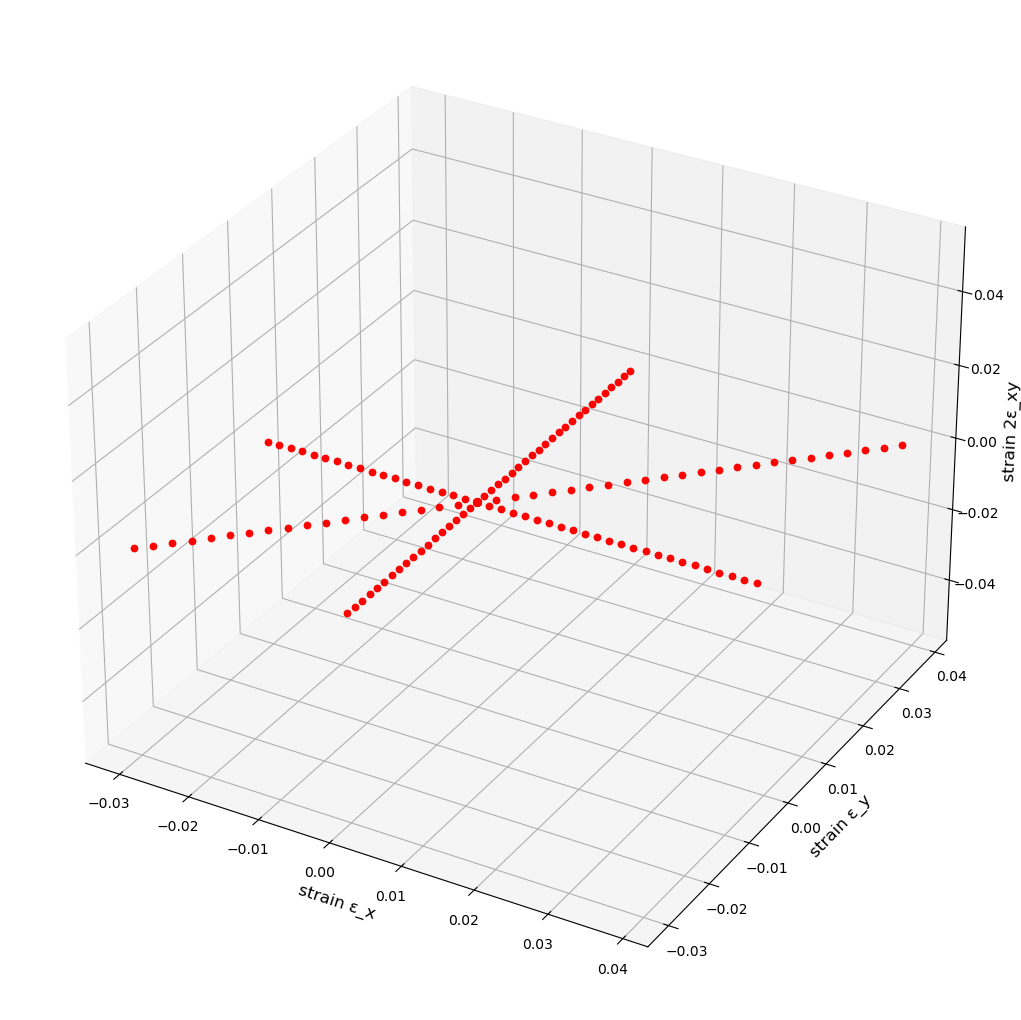

126

In [13]:
# strain_value_dict = "./strain_matrix_dict.pkl" # 单轴拉升和双轴拉升的数据
# strain_value_list = "./strain_matrix.npy"
uniform_strain = False  # uniform strain (Treu) or random for each model
inherit = True  # 是否用继承的坐标启动

num_strain = 10  # 每个构型上的随机应变
random_select = 10  # 从随机应变中挑选的个数，施加在构型上的实际应变
all_model_rotate = 6  # 所有的构型
max_strain = 0.04
strain_box = max_strain * np.array([[-1, 1], [-1, 1], [-1, 1]])  # 应变范围 [ε_x ε_y 2ε_xy]
strain_box[2] = strain_box[2] / 2  #

strain_matrix, strain_matrix_dict = generate_strain_matrix_shear(
    num_strain,
    all_model_rotate,
    strain_box,
    random_select=random_select,
    uniform_strain=uniform_strain,
    inherit=inherit,
    dict_name=strain_value_dict,
    array_name=strain_value_list,
)
test_dict_plot(strain_matrix_dict)
len(strain_matrix_dict.keys())

[0.0022366871208428403, -0.016240502949723845, 0.0030478167875719244]
strain: 
 [[ 0.0022  0.003   0.    ]
 [ 0.003  -0.0162  0.    ]
 [ 0.      0.      0.    ]]


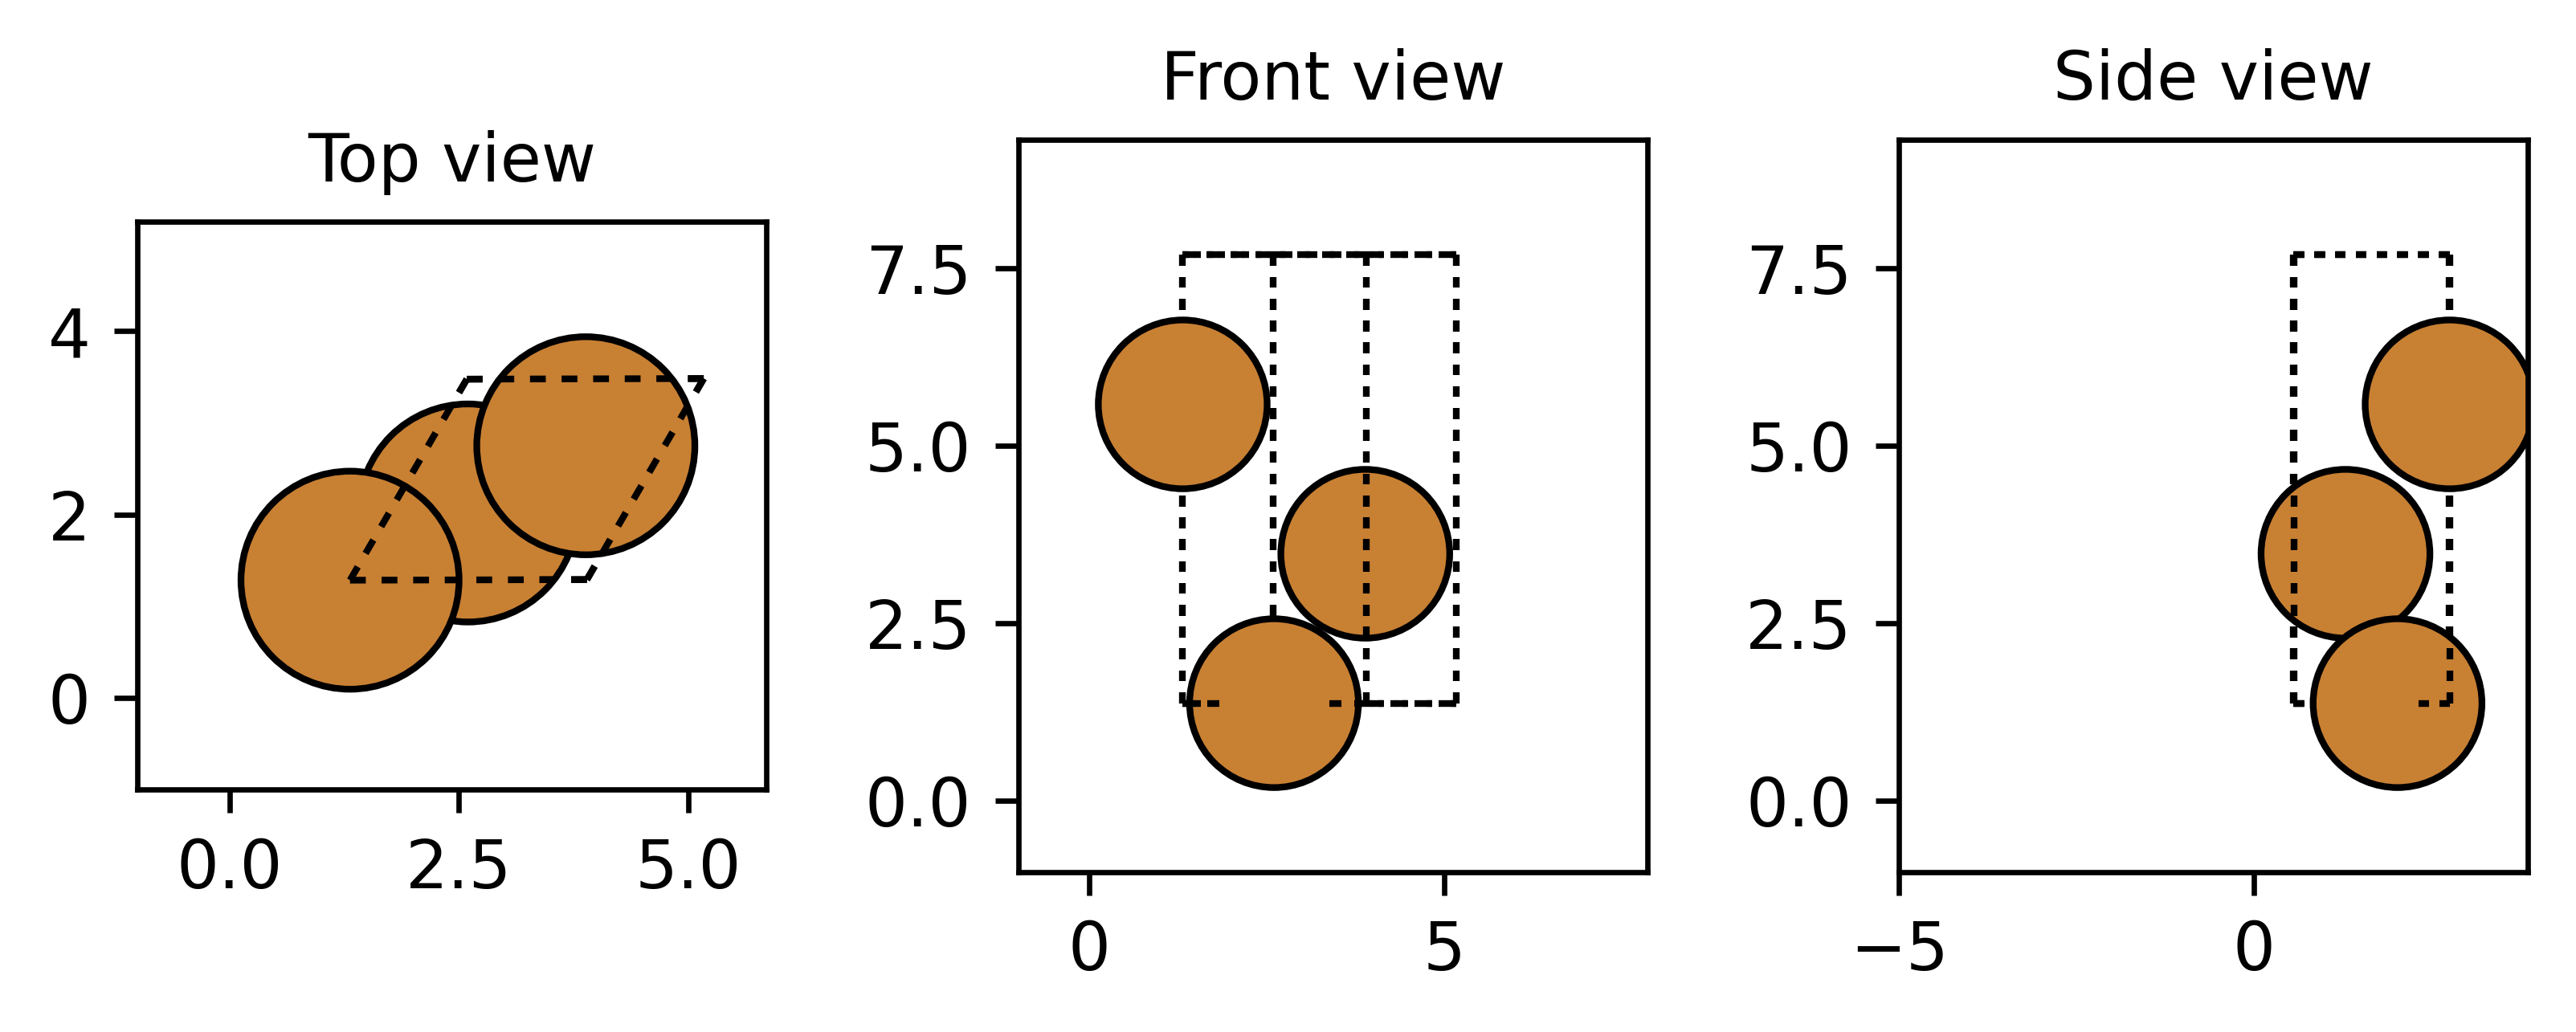

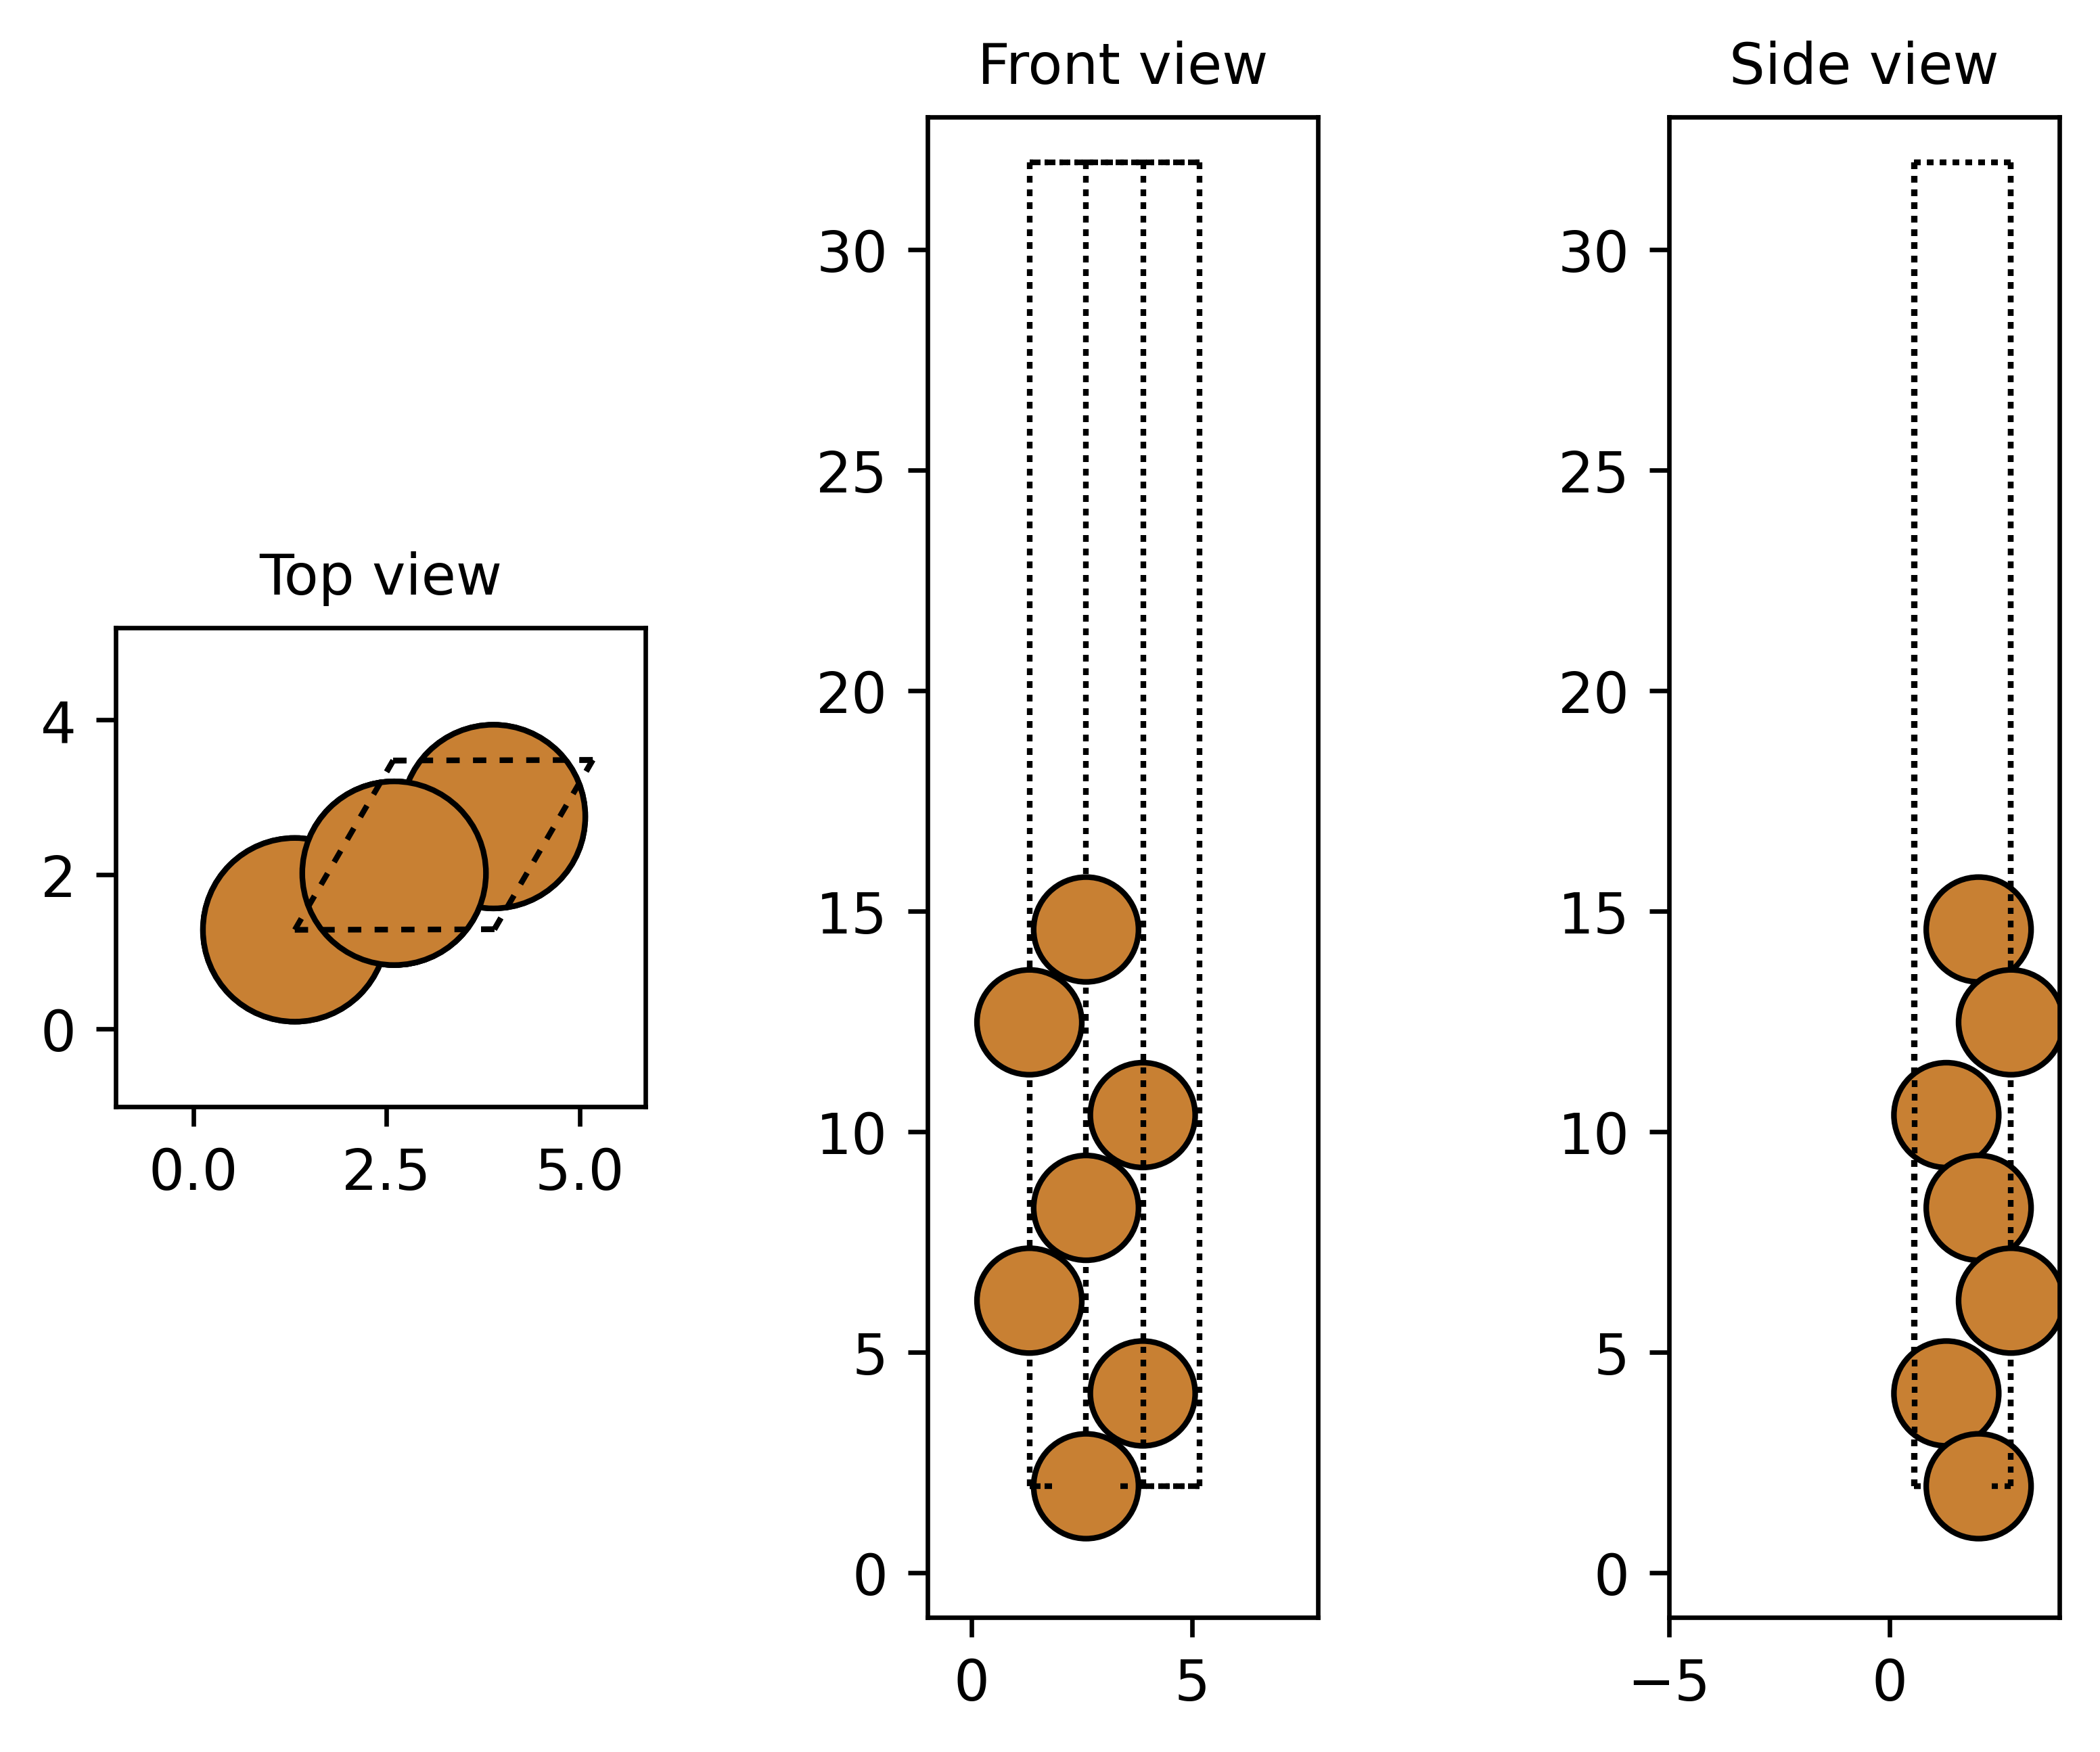

In [14]:
test = True
if test:
    # random.seed(123)
    # 生成随机数
    random_s = [random.uniform(-0.02, 0.02) for _ in range(3)]
    random_s[2] = random_s[2] / 2
    print(random_s)
    strain_bulk, strain_real = opt_strain(bulk, random_s, iscal=False)  # 先加应变
    strain_slab = vac_ext(
        strain_bulk, vacuum_h=30, ads_layer=4
    )  # 再加真空层，默认加完真空层z方向盒子高度30埃
    plot_model(strain_bulk)
    plot_model(strain_slab)
    pos = strain_slab.get_positions()

In [15]:
strain_matrix.shape

(6, 21, 3)

## 3.2 strain bulk

In [16]:
refer_bulk_dict = {}
refer_bulk_list = []
for i in range(strain_matrix.shape[0]):  # 列表和字典都嵌套了两层
    refer_bulk_dict_i = {}
    refer_bulk_list_i = []
    for j in range(strain_matrix.shape[1]):
        strain = strain_matrix[i, j]
        strain_bulk, strain_real = opt_strain(bulk, strain, iscal=False)  # 先加应变
        refer_bulk_list_i.append(strain_bulk)
        refer_bulk_dict_i[f"{str(1000+j)}"] = strain_bulk
    refer_bulk_list.append(refer_bulk_list_i)
    refer_bulk_dict[f"{str(1000+i)}"] = refer_bulk_dict_i

strain: 
 [[-0.03  0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]
strain: 
 [[-0.02  0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]
strain: 
 [[-0.01  0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
strain: 
 [[0.01 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
strain: 
 [[0.02 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
strain: 
 [[0.03 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
strain: 
 [[ 0.    0.    0.  ]
 [ 0.   -0.03  0.  ]
 [ 0.    0.    0.  ]]
strain: 
 [[ 0.    0.    0.  ]
 [ 0.   -0.02  0.  ]
 [ 0.    0.    0.  ]]
strain: 
 [[ 0.    0.    0.  ]
 [ 0.   -0.01  0.  ]
 [ 0.    0.    0.  ]]
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
strain: 
 [[0.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.  ]]
strain: 
 [[0.   0.   0.  ]
 [0.   0.02 0.  ]
 [0.   0.   0.  ]]
strain: 
 [[0.   0.   0.  ]
 [0.   0.03 0.  ]
 [0.   0.   0.  ]]
strain: 
 [[-0.03  0.    0.  ]
 [ 0.   -0.03  0.  ]
 [ 0.    0.    0.  ]

In [17]:
len(refer_bulk_dict)

6

In [18]:
# output POSCAR
# refer_bulk_folder = "/media/zwbai/DATA/dft/shear/refer_bulk"  # 所有应变对应的bulk
out_car_list(refer_bulk_list, path=refer_bulk_folder)

shutil.copy(strain_value_dict, refer_bulk_folder)  # 对应的应变记录文件
shutil.copy(strain_value_list, refer_bulk_folder)

input is list
input is list
input is list
input is list
input is list
input is list


'/media/zwbai/DATA/dft/tc/output/refer_bulk/strain_matrix.npy'

## 3.3 strain slab 

In [19]:
def operate(src_file, dest_file):
    bulk = read(src_file)
    slab = vac_ext(bulk, vacuum_h=30.0, ads_layer=4)
    # slab = move_to_mid(slab)
    write_atoms(dest_file, slab, format="vasp")

In [20]:
exist_folder(refer_bulk_copy)  # 计算完成后，确保计算结果存在

folder '/media/zwbai/DATA/dft/tc/input/refer_bulk_copy' exists


In [21]:
# 复制CONTCAR文件到目标目录并改名为POSCAR
poscar_files = copy_contcar(refer_bulk_copy, refer_slab_folder, func=operate)

write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1000/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1001/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1002/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1003/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1004/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1005/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1006/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1007/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1008/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1009/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1010/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1011/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_slab/1000/1012/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/refer_

get model from bulk to slab after calculation completed.

In [22]:
exist_folder(refer_slab_copy)
strain_slabs_l, strain_slabs_d = read_cars(refer_slab_copy)  # 有应变的基底

folder '/media/zwbai/DATA/dft/tc/input/refer_slab_copy' exists
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1000/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1001/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1002/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1003/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1004/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1005/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1006/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1007/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1008/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1009/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1010/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1011/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1012/CONTCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1013/CONTCAR
/media/zwbai/DATA/dft/tc/in

# 4. Adsorbed molecule

## 4.1 atom positions

In [23]:
print(slab_op.constraints)
slab_op.set_constraint()  # 清除约束
print(slab_op.constraints)

[FixScaled(array([[ 2.5715,  0.    ,  0.    ],
       [ 1.2857,  2.227 ,  0.    ],
       [ 0.    ,  0.    , 30.    ]]), 5, array([ True,  True, False])), FixScaled(array([[ 2.5715,  0.    ,  0.    ],
       [ 1.2857,  2.227 ,  0.    ],
       [ 0.    ,  0.    , 30.    ]]), 6, array([ True,  True, False])), FixAtoms(indices=[0, 1, 2, 3, 4])]
[]


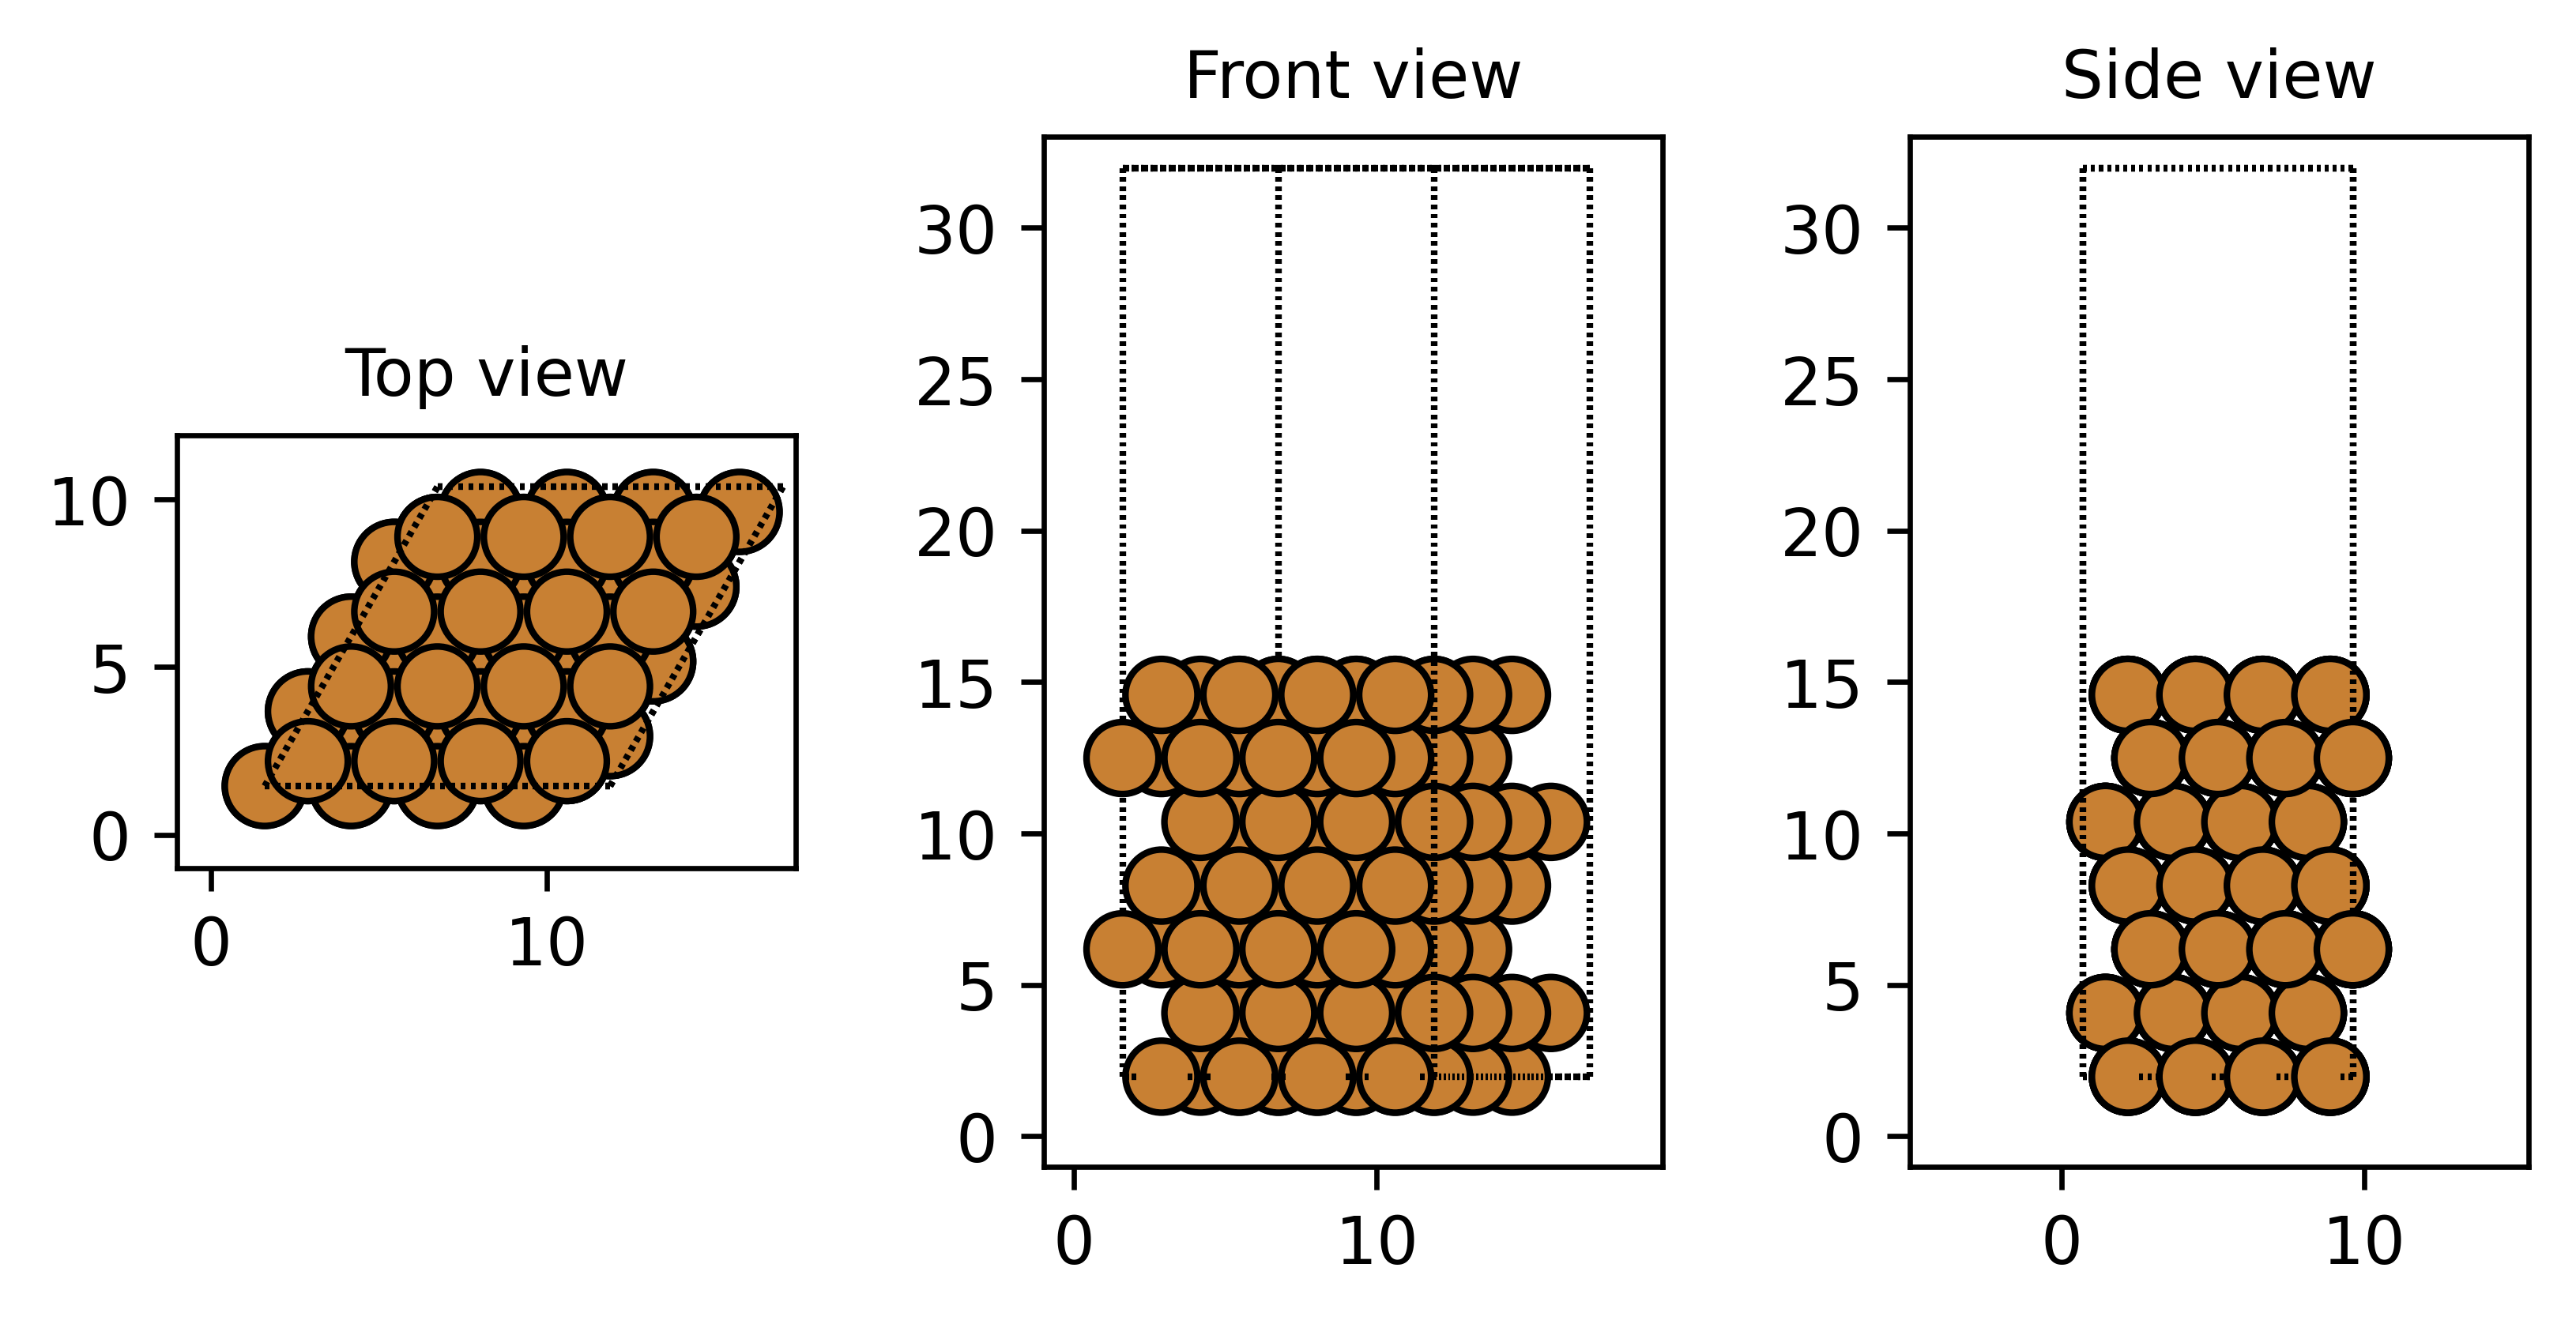

[FixAtoms(indices=[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 98, 99, 100, 101, 102, 105, 106, 107, 108, 109]), FixCartesian(a=[5, 6, 12, 13, 19, 20, 26, 27, 33, 34, 40, 41, 47, 48, 54, 55, 61, 62, 68, 69, 75, 76, 82, 83, 89, 90, 96, 97, 103, 104, 110, 111], mask=[True, True, False])]
[0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0
 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2]
input is Atoms
write ------ /media/zwbai/DATA/dft/tc/output/Cu_slab4/POSCAR


In [24]:
adslab = slab_op.copy()
adslab = adslab.repeat((4, 4, 1))
adslab = set_cons0(adslab)
plot_model(adslab)
print(adslab.constraints)
print(adslab.get_tags())
out_poscar(adslab, path=Cu_slab4_folder)  # 放大的基底

In [25]:
adslab = read_one_car(Cu_slab4_copy)

adslab = set_cons1(adslab)
print(adslab.constraints)
print(adslab.get_tags())
print(len(adslab) - len(adslab.constraints[0].index))
# out_poscar(adslab1, path = './vasp_cala/Cu_slab4') # 放大的基底

/media/zwbai/DATA/dft/tc/input/Cu_slab4_copy/CONTCAR
[FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110])]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  1 -1  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1 -1  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0
  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0
  0  0  0  0  1  2]
13


In [26]:
positions = adslab.get_positions()  # 笛卡尔坐标
cell = np.array(adslab.get_cell())  # 盒子
tags = adslab.get_tags()
frac_pos = adslab.get_scaled_positions()  # 分数坐标
postop = frac_pos[np.logical_or(tags == 2, tags == -1)]
index = np.array(range(len(adslab)))
indextop = index[np.logical_or(tags == 2, tags == -1)]

In [27]:
print(len(postop))
postop

16


array([[0.0833, 0.0833, 0.4192],
       [0.0833, 0.3333, 0.4192],
       [0.0833, 0.5833, 0.4192],
       [0.0833, 0.8333, 0.4192],
       [0.3333, 0.0833, 0.4192],
       [0.3333, 0.3333, 0.4192],
       [0.3333, 0.5833, 0.4192],
       [0.3333, 0.8333, 0.4192],
       [0.5833, 0.0833, 0.4192],
       [0.5833, 0.3333, 0.4192],
       [0.5833, 0.5833, 0.4192],
       [0.5833, 0.8333, 0.4192],
       [0.8333, 0.0833, 0.4192],
       [0.8333, 0.3333, 0.4192],
       [0.8333, 0.5833, 0.4192],
       [0.8333, 0.8333, 0.4192]])

In [28]:
top3d = [
    [indextop[i] for i in [10, 11, 14, 15]],
    [indextop[i] for i in [10, 11, 14, 7]],
    [indextop[i] for i in [10, 11, 14, 13]],
]
# 对应的是四个原子3个旋转角度的
top3d

[[76, 83, 104, 111], [76, 83, 104, 55], [76, 83, 104, 97]]

In [29]:
mask = top3d[0]
# 为了获得单原子的四个稳定吸附位点
top = positions[mask]
frac_top = frac_pos[mask]
frac_top

array([[0.5833, 0.5833, 0.4192],
       [0.5833, 0.8333, 0.4192],
       [0.8333, 0.5833, 0.4192],
       [0.8333, 0.8333, 0.4192]])

In [30]:
# 分别要计算四个单原子的参考位置
pos = np.zeros((4, 3))
for i in range(4):
    pos[i] = np.mean(top[max([i - 2, 0]) : i + 1], axis=0)
    # 一个 两个 三个 原子的平均，对应的是吸附原子的位置
pos[:, 2] = 0
pos  # 三个原子的x和y的位置

array([[ 9.0001,  5.1962,  0.    ],
       [ 9.643 ,  6.3097,  0.    ],
       [10.2859,  5.9385,  0.    ],
       [11.5716,  6.6809,  0.    ]])

[ 9.0001  5.1962 14.4157]
[ 9.643   6.3097 14.1677]
[10.2859  5.9385 14.1169]
[11.5716  6.6809 14.1171]


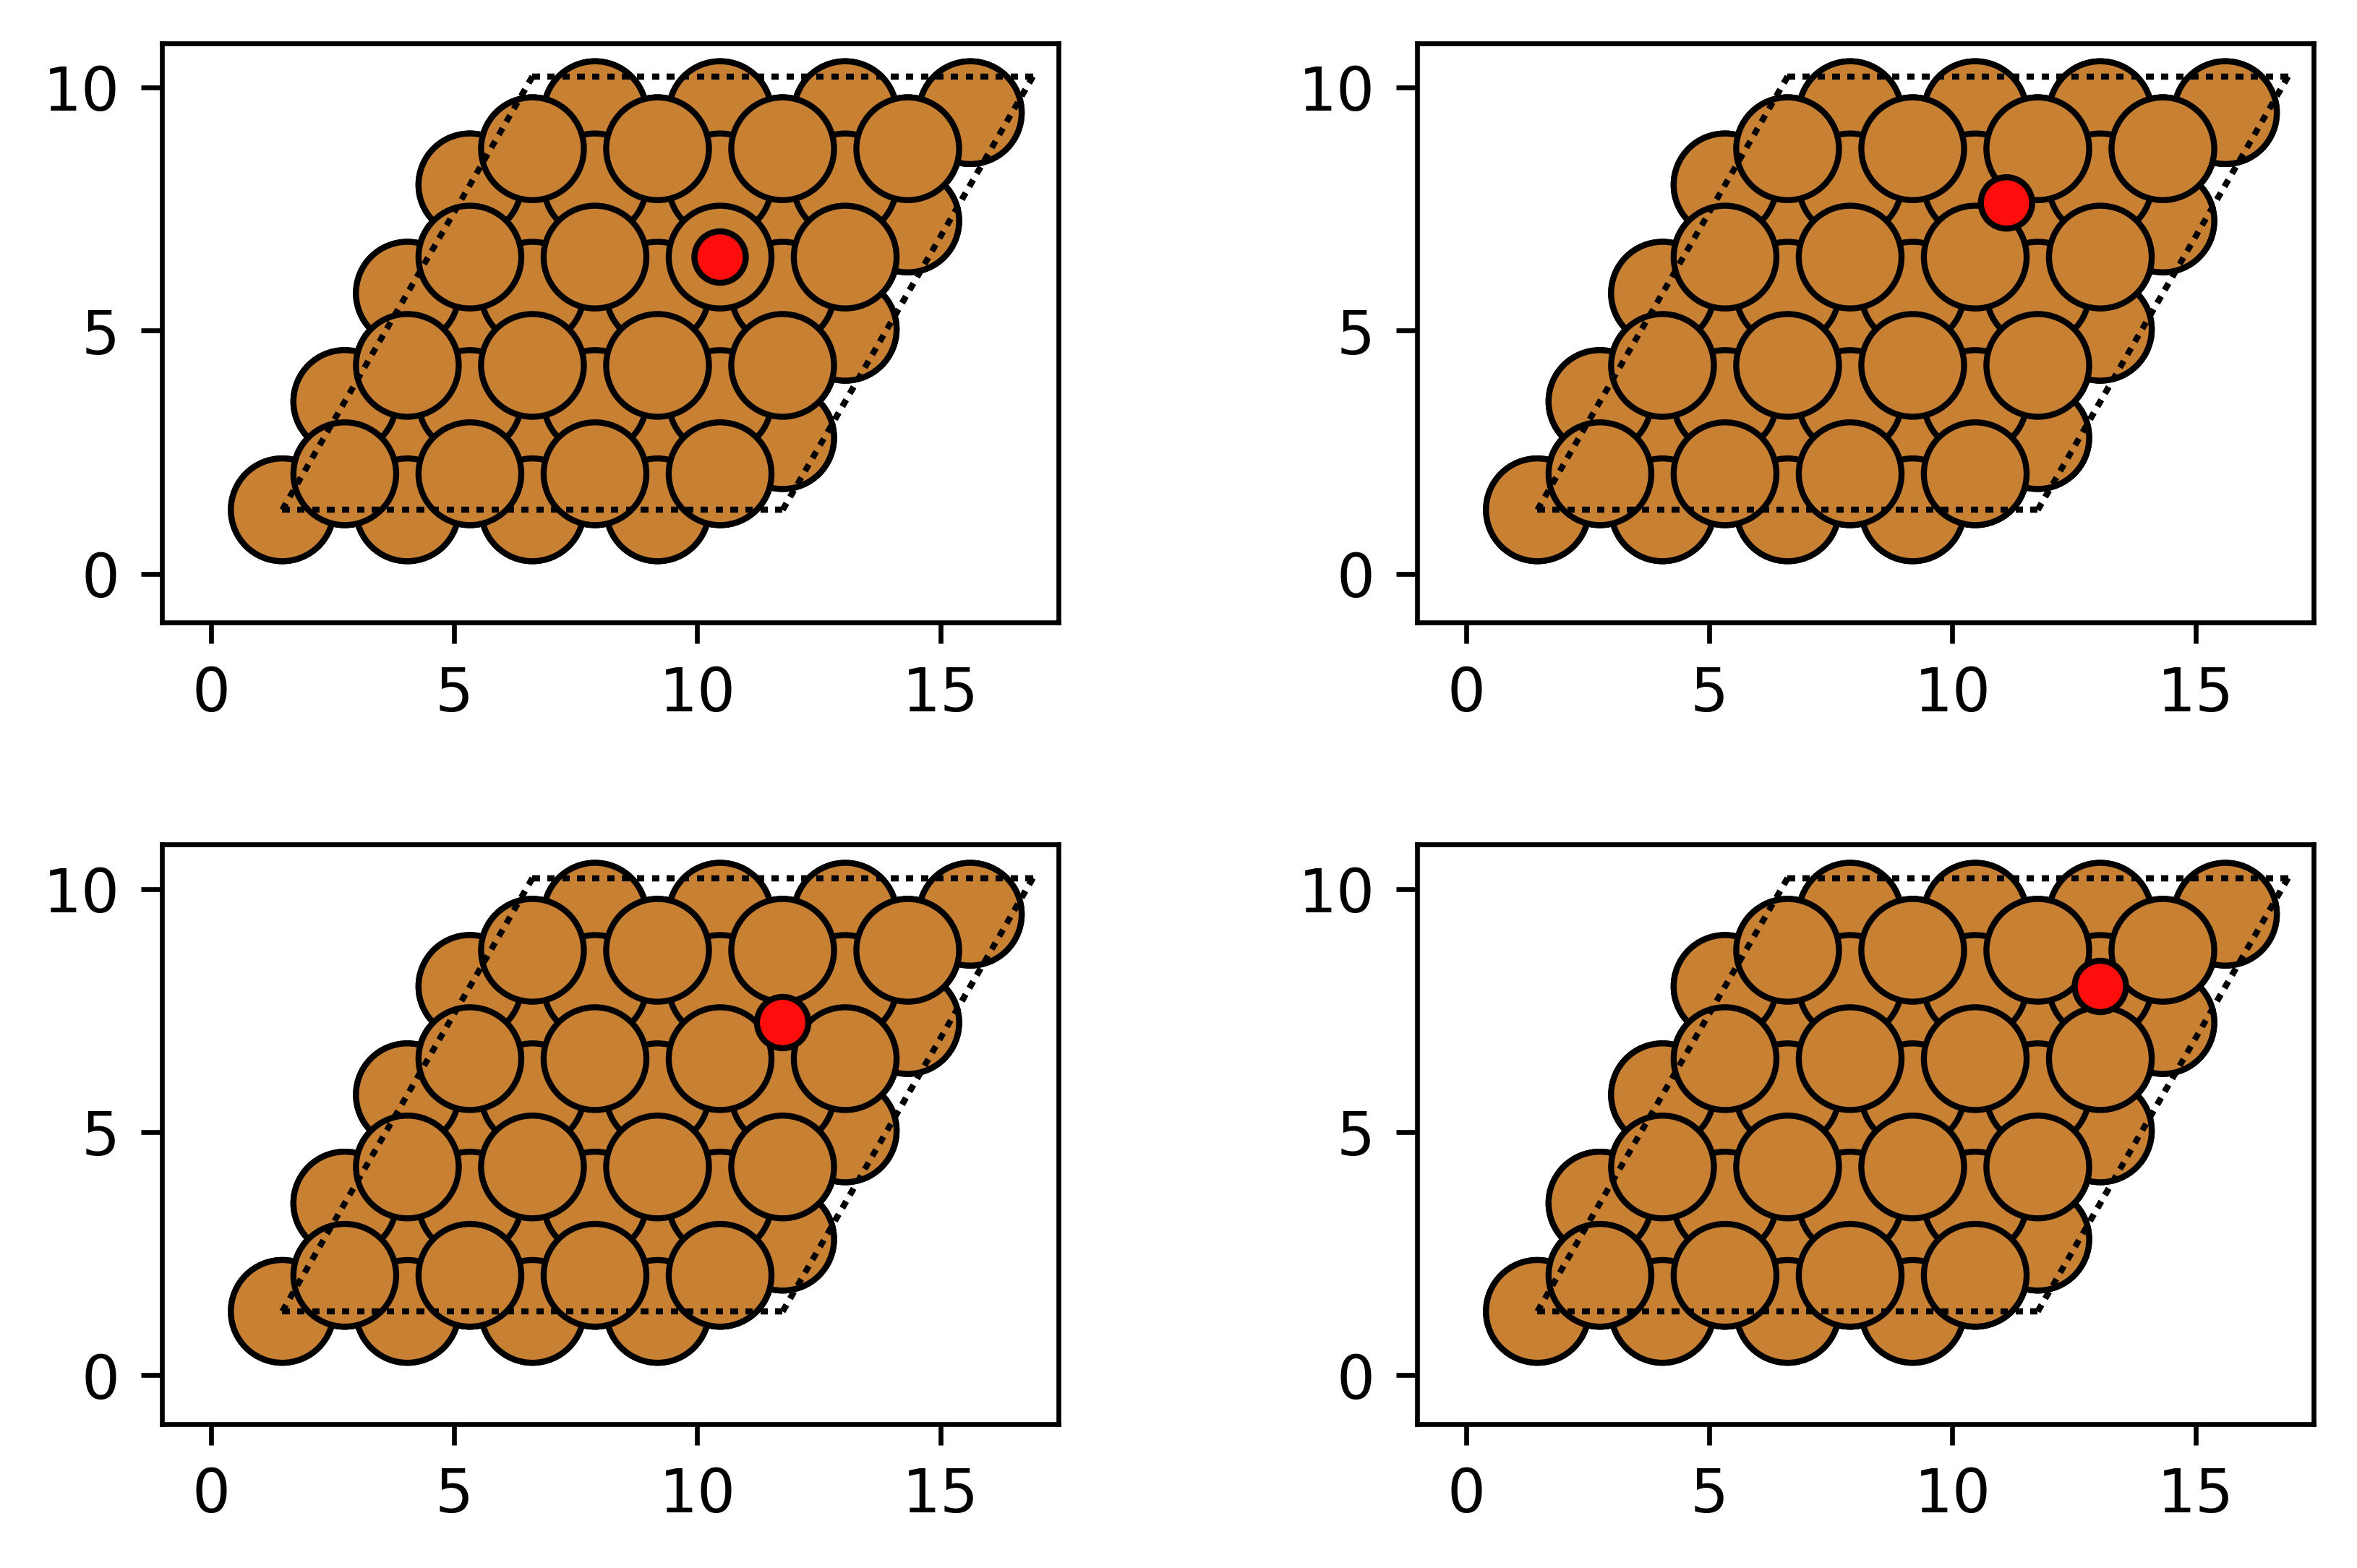

input is dict
write ------ /media/zwbai/DATA/dft/tc/output/one_atom/top_0/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/one_atom/bri_12/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/one_atom/hol_012/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/one_atom/hol_123/POSCAR


In [31]:
ads = molecule("O", positions=[(0, 0, 0)])
atom_model_cala = []
order = ["top_0", "bri_12", "hol_012", "hol_123"]
height = 1.0
for i in range(4):
    adslab0 = adslab.copy()
    position = pos[i, :2]
    offset = (0, 0)
    add_adsorbate(adslab0, ads, height, position=position, offset=offset)

    adslab0 = set_cons2(adslab0)
    adslab0, _ = cal_LBFGC(adslab0)
    atom_model_cala.append(adslab0)
    print(adslab0.get_positions()[-1])
atom_model_dict = dict(zip(order, atom_model_cala))

plot_top(atom_model_cala, column=2)
# folder_path = "./vasp_cala/one_atoms/"
out_poscar(atom_model_dict, path=one_atom_folder)  # 新的单原子构型

/media/zwbai/DATA/dft/tc/input/one_atom_copy/bri_12/CONTCAR
/media/zwbai/DATA/dft/tc/input/one_atom_copy/hol_012/CONTCAR
/media/zwbai/DATA/dft/tc/input/one_atom_copy/hol_123/CONTCAR
/media/zwbai/DATA/dft/tc/input/one_atom_copy/top_0/CONTCAR
1st dict_keys(['bri_12', 'hol_012', 'hol_123', 'top_0'])


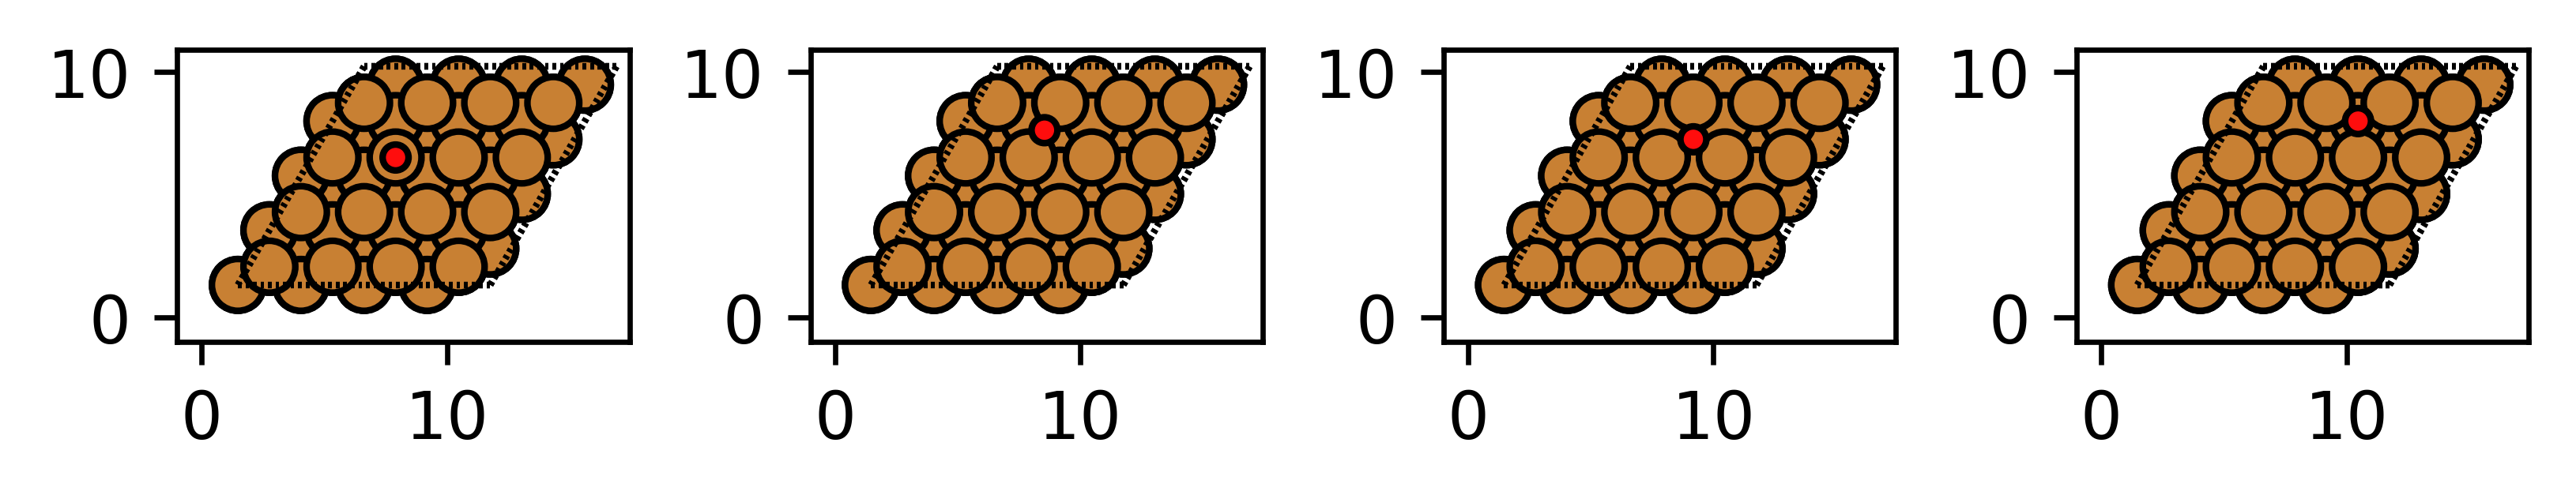

In [32]:
one_atoms_list, one_atoms_dict = read_car(
    one_atom_copy, car="CONTCAR"
)  # car = 'CONTCAR'
one_atoms_list = [one_atoms_dict[i] for i in order]
plot_top(one_atoms_list, column=4)

In [33]:
[one_atoms_list[i].get_positions()[-1, -1] for i in range(len(one_atoms_list))]

[14.308458547612775, 13.890649479568673, 13.755736412769938, 13.76762035462312]

## 4.2 molecule positions

In [34]:
def get_dic(adslab, atom_model):
    tags = adslab.get_tags()
    position = adslab.positions
    # top = position[tags >= 1]
    frac_pos = adslab.get_scaled_positions()
    # frac_top = frac_pos[tags >= 1]
    tags = adslab.get_tags()  # 原子标签
    mask = (
        np.logical_or(tags == 2, tags == -1)
        & (frac_pos[:, 0] > 0.5)
        & (frac_pos[:, 1] > 0.5)
    )
    four_a = position[mask]
    # four_a = top[(frac_top[:,0]>0.3) & (frac_top[:,0]<0.7)
    #                 & (frac_top[:,1]>0.3)& (frac_top[:,1]<0.7)] # 找到需要的四个原子
    points = four_a[:, :2]  # 4个原子的x和y坐标
    from sklearn.neighbors import KDTree

    # 创建一个 KDTree 对象，用于快速搜索最近邻点
    tree = KDTree(points)
    # 使用列表保存每个点的邻居
    neighbor_list = []
    relation_list = []
    for i in range(len(points)):
        # 找到该点距离小于等于 2 的所有邻居
        neighbor = tree.query_radius([points[i]], r=3)[
            0
        ]  # r=3 it is need less then lattice 3.615
        # 排除掉自身，并将结果加入邻居列表中
        # neighbor = [n for n in neighbor if n != i]
        neighbor_list.append(neighbor)
        neighbor = [n for n in neighbor if n > i]
        relation_list.append(neighbor)  # 只统计比自己大的邻居，避免重复
    # 获取相邻元素个数大于 2 的元素
    tri2 = [n for n in neighbor_list if len(n) < 4]
    top_dict = {f"top_{str(i)}": points[i] for i in range(len(points))}
    bri_dict = {}  # bridge 位置的坐标
    for i in range(len(relation_list)):  # i < j 之前定义好了
        for j in relation_list[i]:
            bri_dict[f"bri_{str(i)}{str(j)}"] = np.mean(points[[i, j], :], axis=0)
            xs, ys = zip(*points[[i, j], :])
            # 使用 plot 函数将点连成一条线
            plt.plot(xs, ys, color="red", linewidth=1)
    hol_dict = {}  # hollow 位置的坐标
    for item in tri2:
        tri1 = item
        tri = points[tri1]
        hol_dict[f"hol_{str(tri1[0])}{str(tri1[1])}{str(tri1[2])}"] = np.mean(
            tri, axis=0
        )
    plt.plot(points[:, 0], points[:, 1], "o")
    all_dict = [top_dict, bri_dict, hol_dict]
    for i in range(3):
        data = all_dict[i]
        for key, value in data.items():
            plt.scatter(value[0], value[1], s=100)
            plt.text(value[0], value[1], key, fontsize=15)
    # 显示图形
    plt.axis("equal")
    plt.show()
    # 依据单原子的吸附高度补充字典中z方向的值
    mel_dict = {}
    for i in range(2):
        data = all_dict[i]
        z_value = atom_model[i].positions[-1, -1]
        z_value = np.array([z_value])
        for key, value in data.items():
            data[key] = np.concatenate((data[key][:2], z_value))  # 调整z值
        mel_dict |= all_dict[i]
    # python 的变量具有地址，所以内部的三个字典本体也发生了变化。

    data = all_dict[2]  # 其中是 hol_012(FCC) 和 hol_123(HCP)
    for i, (key, value) in enumerate(data.items(), start=2):
        z_value = atom_model[i].positions[-1, -1]
        z_value = np.array([z_value])
        data[key] = np.concatenate((data[key][:2], z_value))  # 调整z值
    mel_dict |= all_dict[2]
    return mel_dict

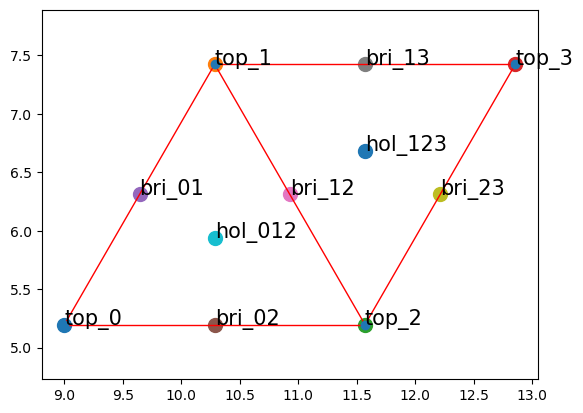

In [35]:
mel_dict = get_dic(adslab, one_atoms_list)
molecule_name = [
    # ["top_0", "top_1"],
    # ["top_0", "bri_12"],
    # ['top_0',    'bri_01'], # 能量偏高，并不稳定
    ["top_0", "hol_123"], # shear2 2
    # ["top_0", "hol_012"],
    # ["hol_012", "bri_23"],  # shear 4
    # ['hol_012',  'bri_01'], # 能量偏高，并不稳定
    ["hol_123", "bri_02"], # shear2 5
    # ['hol_123',  'bri_23'], # 能量偏高，并不稳定
    # ["hol_012", "hol_123"],
    # ["bri_02", "bri_13"],  # shear 7
    # ["bri_02", "bri_12"],
]
mol = np.zeros([len(molecule_name), 2, 3])  # 储存三维点坐标
for i in range(len(molecule_name)):
    mol_o2 = np.array([mel_dict[molecule_name[i][0]], mel_dict[molecule_name[i][1]]])
    mol[i] = mol_o2

In [36]:
result = []
for row in molecule_name:
    temp = []
    for s in row:
        num_str = "".join(filter(str.isdigit, s))
        if num_str != "":
            temp.append(num_str)
    result.append(temp)
result  # 六个通道的特征

[['0', '123'], ['123', '02']]

In [37]:
mol_num = len(mol)
molecule_model = []
for i in range(mol_num):
    ads = molecule("O2", positions=mol[i])
    adslab0 = adslab.copy()
    height = mol[i][0][-1] - adslab.positions[-1][-1]
    add_adsorbate(adslab0, ads, height, position=(mol[i][0][:2]), offset=(0, 0))
    # tags = adslab0.get_tags()
    # tags[36:] = 3  # 吸附分子
    # adslab0.set_tags(tags) # 将tags属性替换
    # cons0 = adslab0.constraints[0]
    # cons1 = FixCartesian([len(tags)-2,len(tags)-1],mask=(1, 1, 0))
    adslab0 = set_cons2(adslab0)
    molecule_model.append(adslab0)
    print(adslab0.positions[-2:, -1])

[14.3085 13.7676]
[13.7676 13.8906]


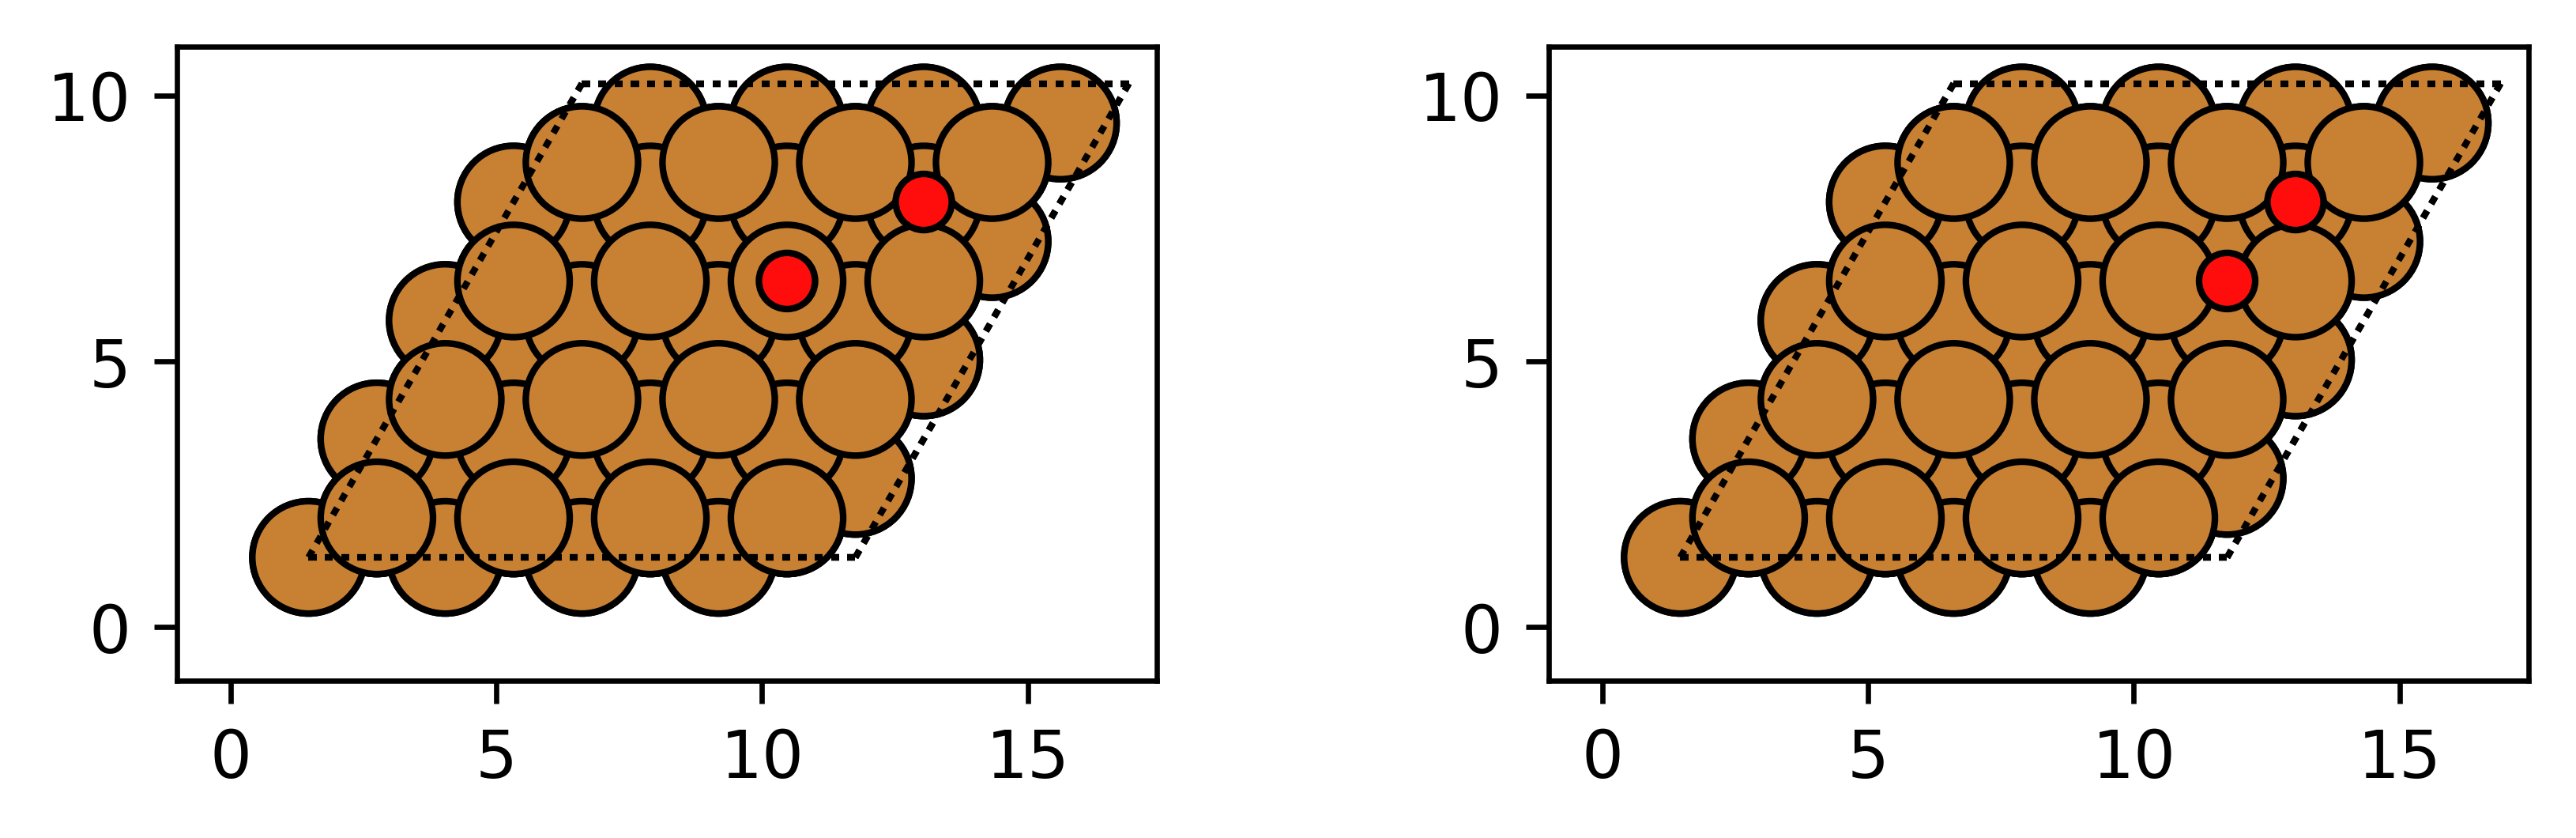

In [38]:
plot_top(molecule_model, column=2)

In [39]:
molecule_model[0].get_positions()[-2:]

array([[ 9.0001,  5.1962, 14.3085],
       [11.5716,  6.6809, 13.7676]])

In [40]:
# output POSCAR
out_poscar(molecule_model, nostrain_molecule_folder)

input is list
write ------ /media/zwbai/DATA/dft/tc/output/nostrain_molecule/1000/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/nostrain_molecule/1001/POSCAR


wait calculation complete

In [41]:
molecule_model_relax_l, molecule_model_relax_d = read_car(
    nostrain_molecule_copy, car="CONTCAR"
)  # car='CONTCAR'

/media/zwbai/DATA/dft/tc/input/nostrain_molecule_copy/1000/CONTCAR
/media/zwbai/DATA/dft/tc/input/nostrain_molecule_copy/1001/CONTCAR
1st dict_keys(['1000', '1001'])


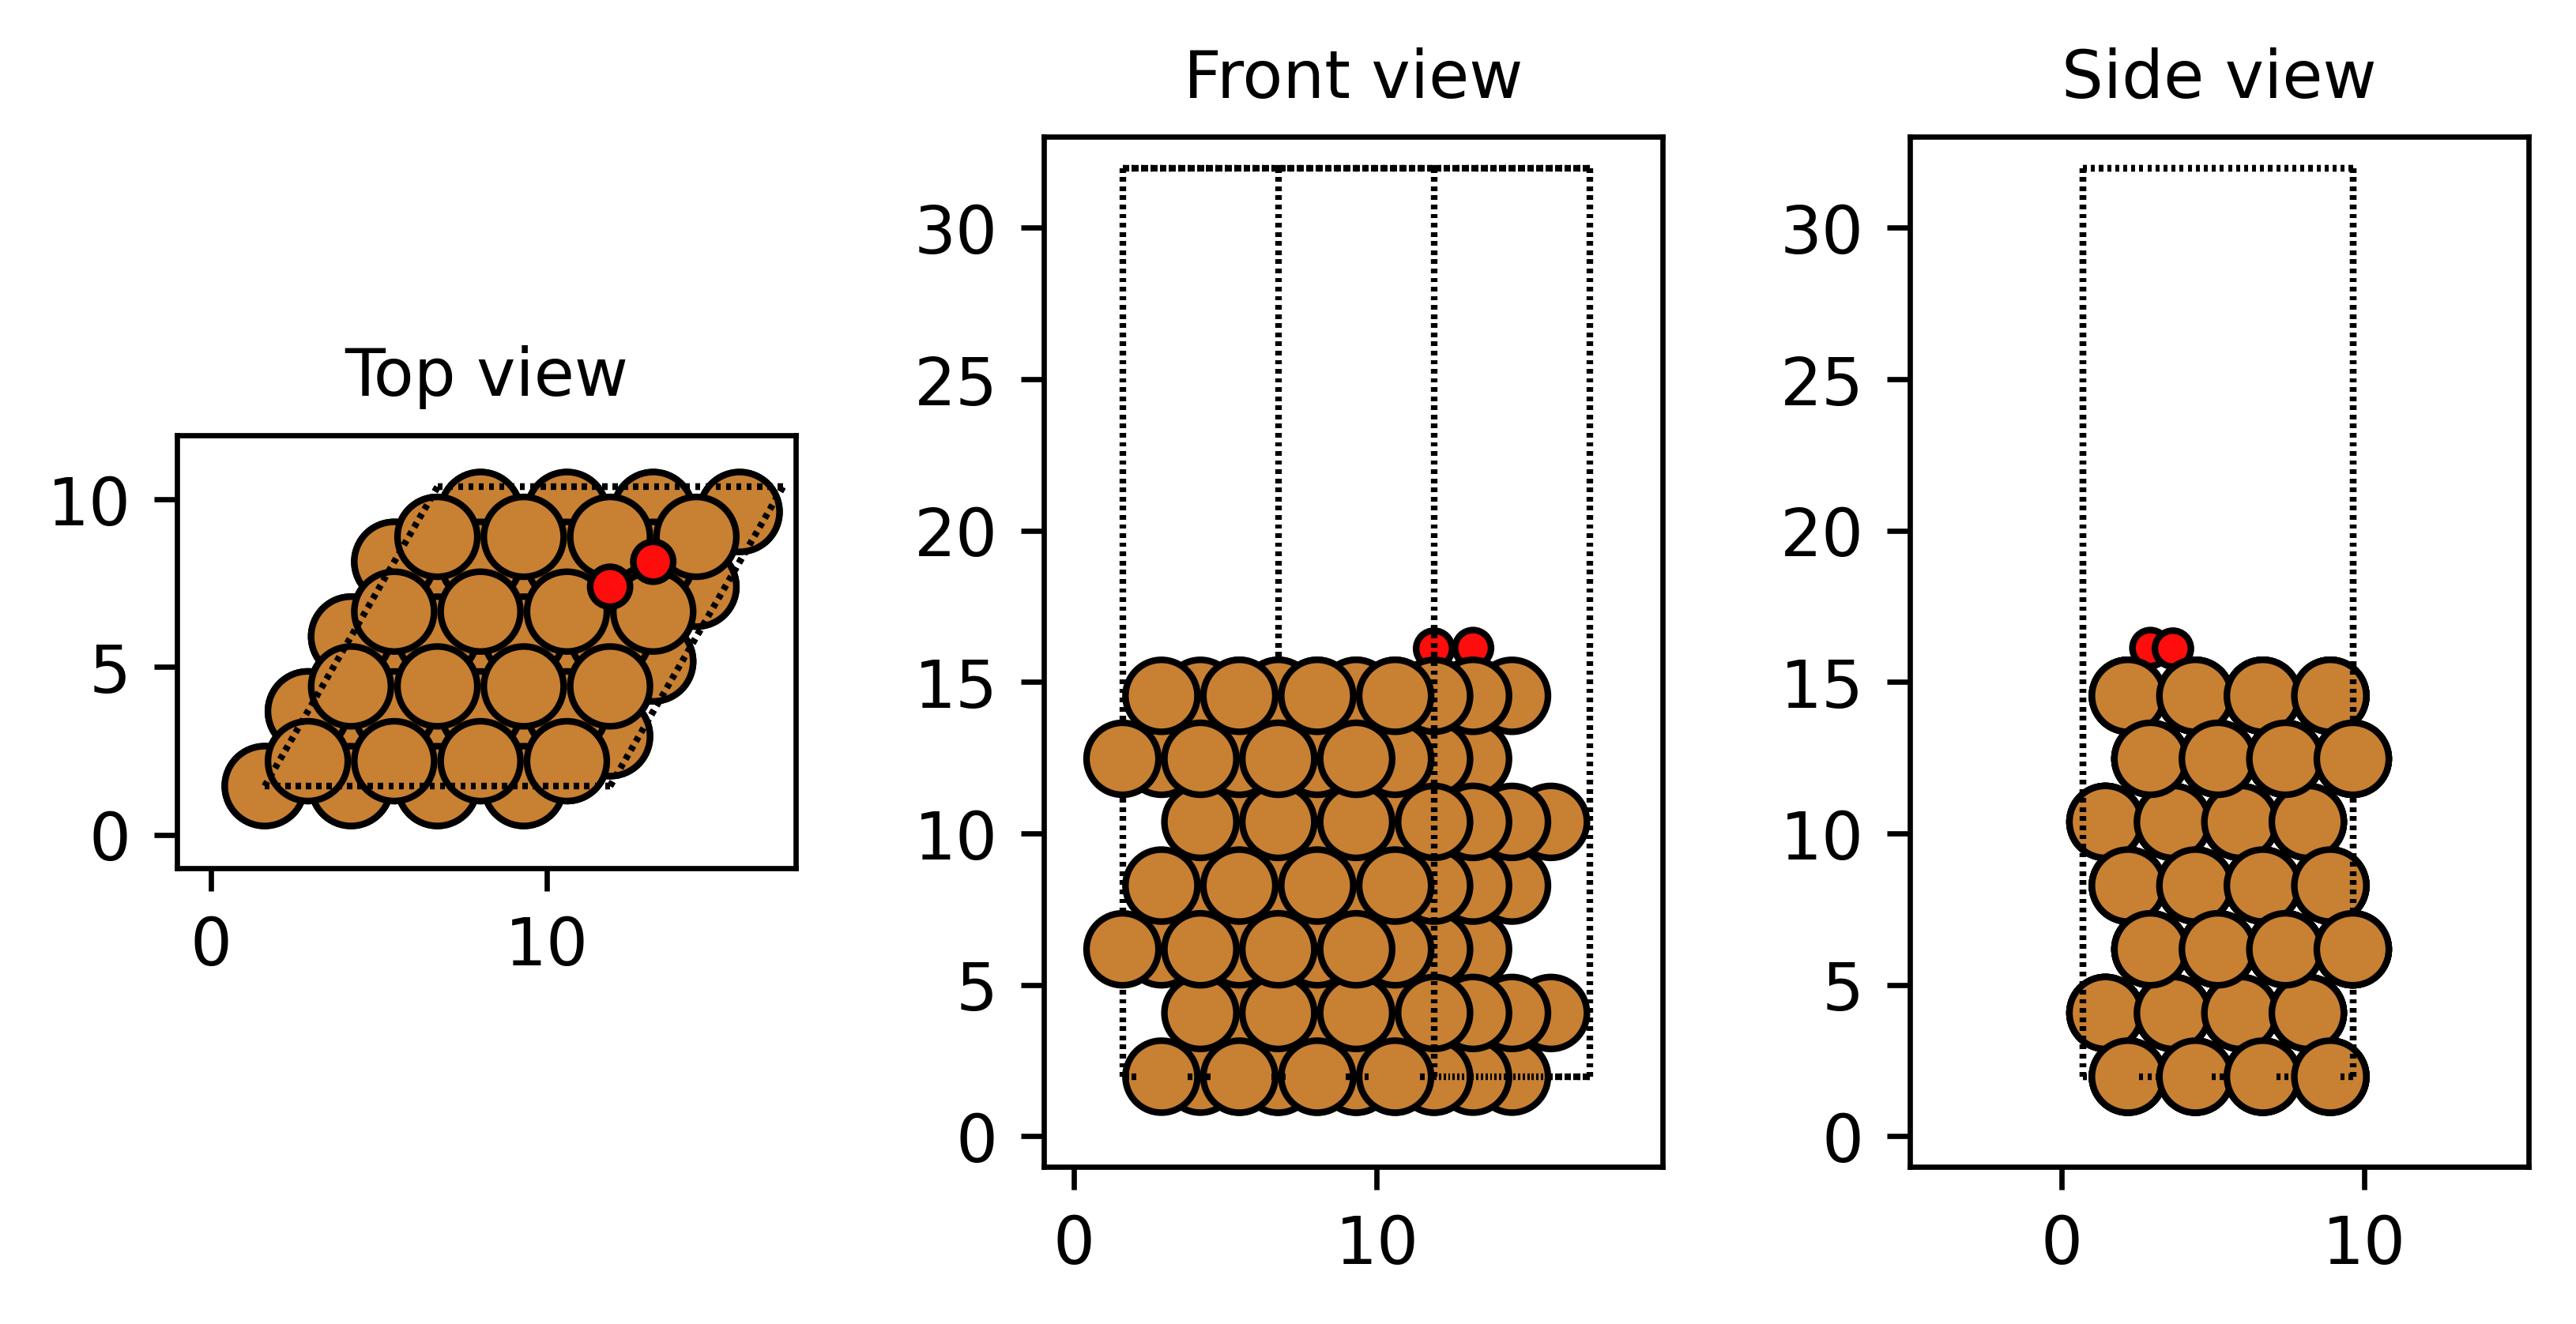

In [42]:
plot_model(molecule_model_relax_d["1001"])

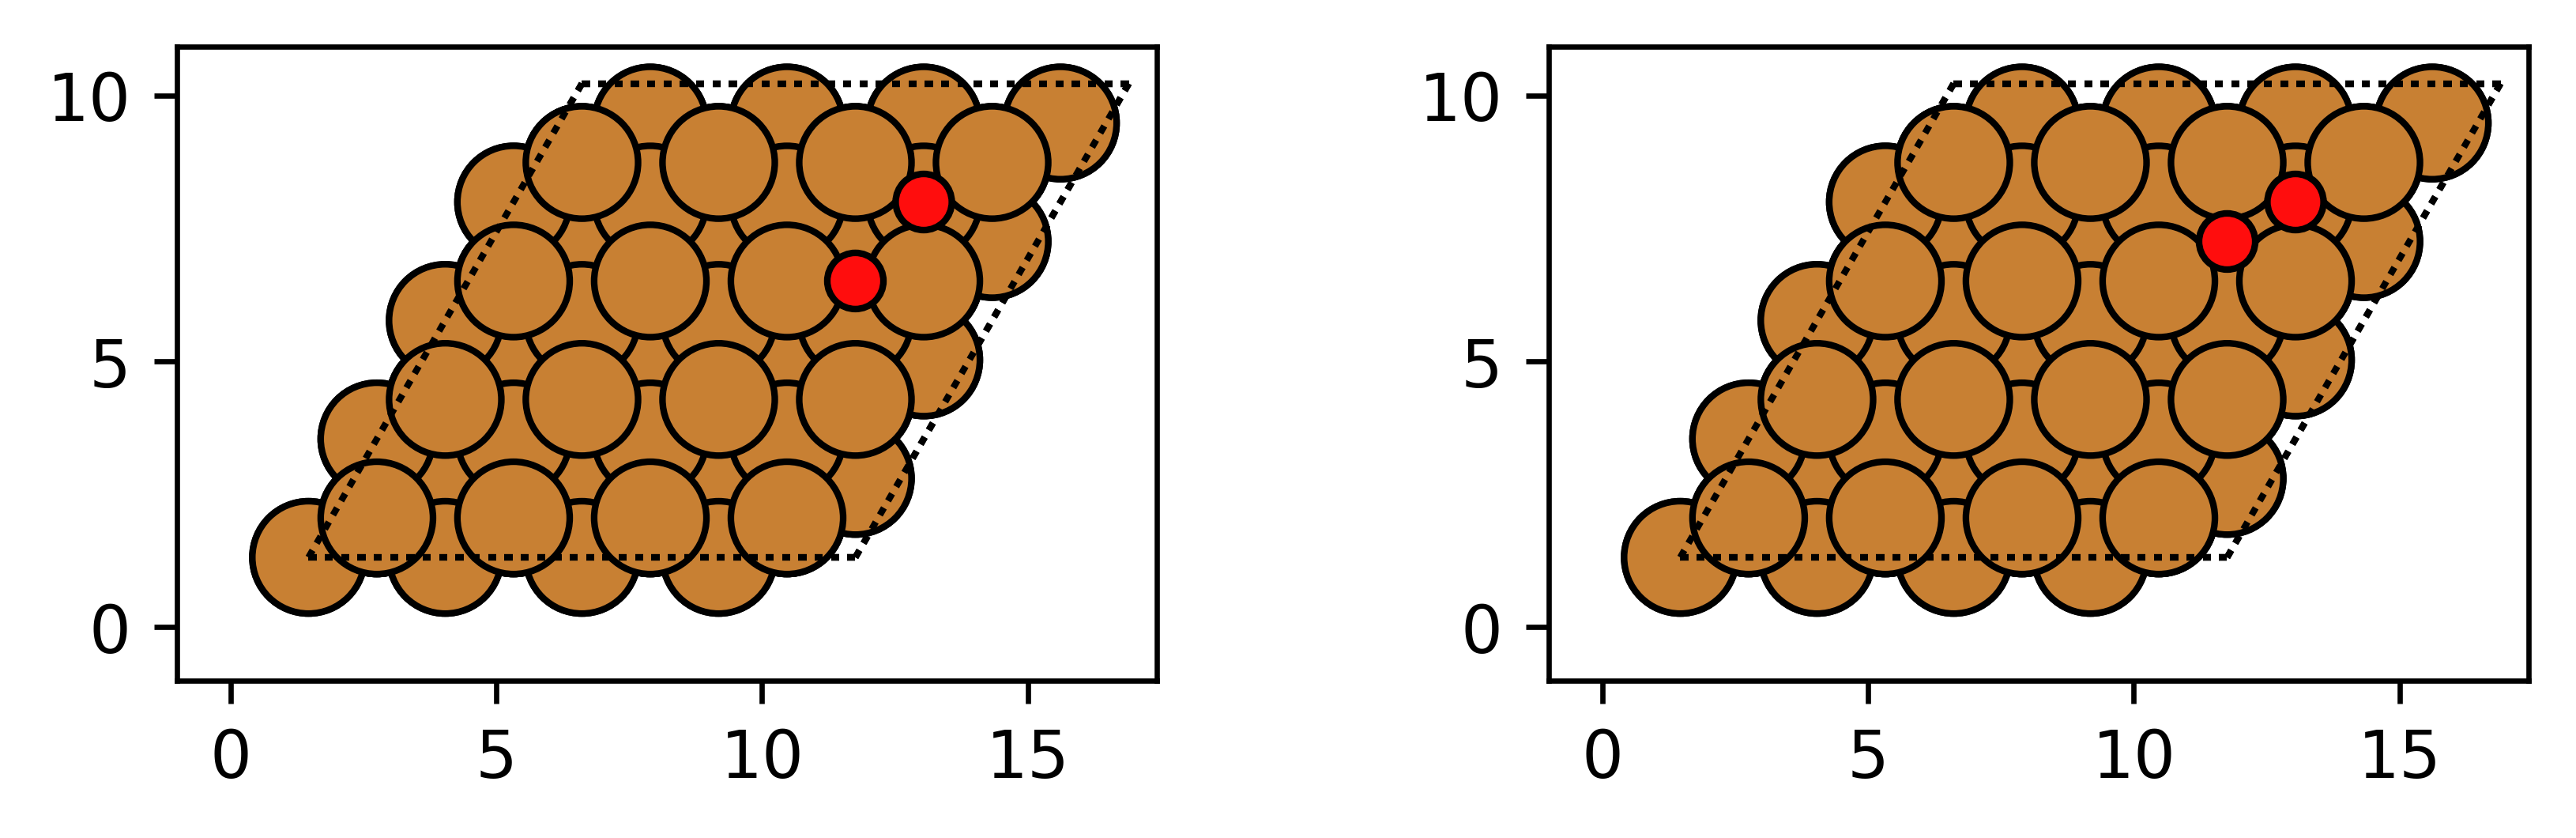

In [43]:
plot_top(molecule_model_relax_l, column=2)

In [44]:
molecule_energy_relax_l, molecule_energy_relax_d = read_car(
    nostrain_molecule_copy, car="OSZICAR"
)

E0 value: -1 F   -.41322994E+03
/media/zwbai/DATA/dft/tc/input/nostrain_molecule_copy/1000/OSZICAR
E0 value: -1 F   -.41269243E+03
/media/zwbai/DATA/dft/tc/input/nostrain_molecule_copy/1001/OSZICAR
1st dict_keys(['1000', '1001'])


## 4.3 Rotate

Asymmetric strain can cause configuration asymmetry

In [45]:
def rotate_point(points, axis, angle=120):
    new_points = points
    for i in range(len(points)):
        point = points[i]
        x = point[0]
        y = point[1]
        a = axis[0]
        b = axis[1]
        theta = math.radians(angle)  # 计算旋转角度，将角度转换为弧度
        x_new = a + (x - a) * math.cos(theta) - (y - b) * math.sin(theta)
        y_new = b + (x - a) * math.sin(theta) + (y - b) * math.cos(theta)
        new_point = np.array([x_new, y_new])
        new_points[i] = new_point
    return new_points

In [46]:
molecule_dic = {}
for i in range(len(molecule_name)):
    molecule_text = f"{molecule_name[i][0]}_{molecule_name[i][1]}"
    molecule_dic[molecule_text] = molecule_model_relax_l[i]

mol_rotate_dic = {}
axis = mel_dict["hol_012"]
axis = axis[:2]
for key, r in itertools.product(molecule_dic, range(3)):
    ra = 120 * (r)  # rotate angle
    # print(molecule_dic[key])
    adslab0 = molecule_dic[key].copy()
    xypos = adslab0.positions[-2:, :2]
    xypos = rotate_point(xypos, axis, angle=ra)
    adslab0.positions[-2:, :2] = xypos
    mol_rotate_dic[f"{key}_{str(ra)}"] = adslab0
len(mol_rotate_dic)
mol_rotate_list = list(mol_rotate_dic.values())

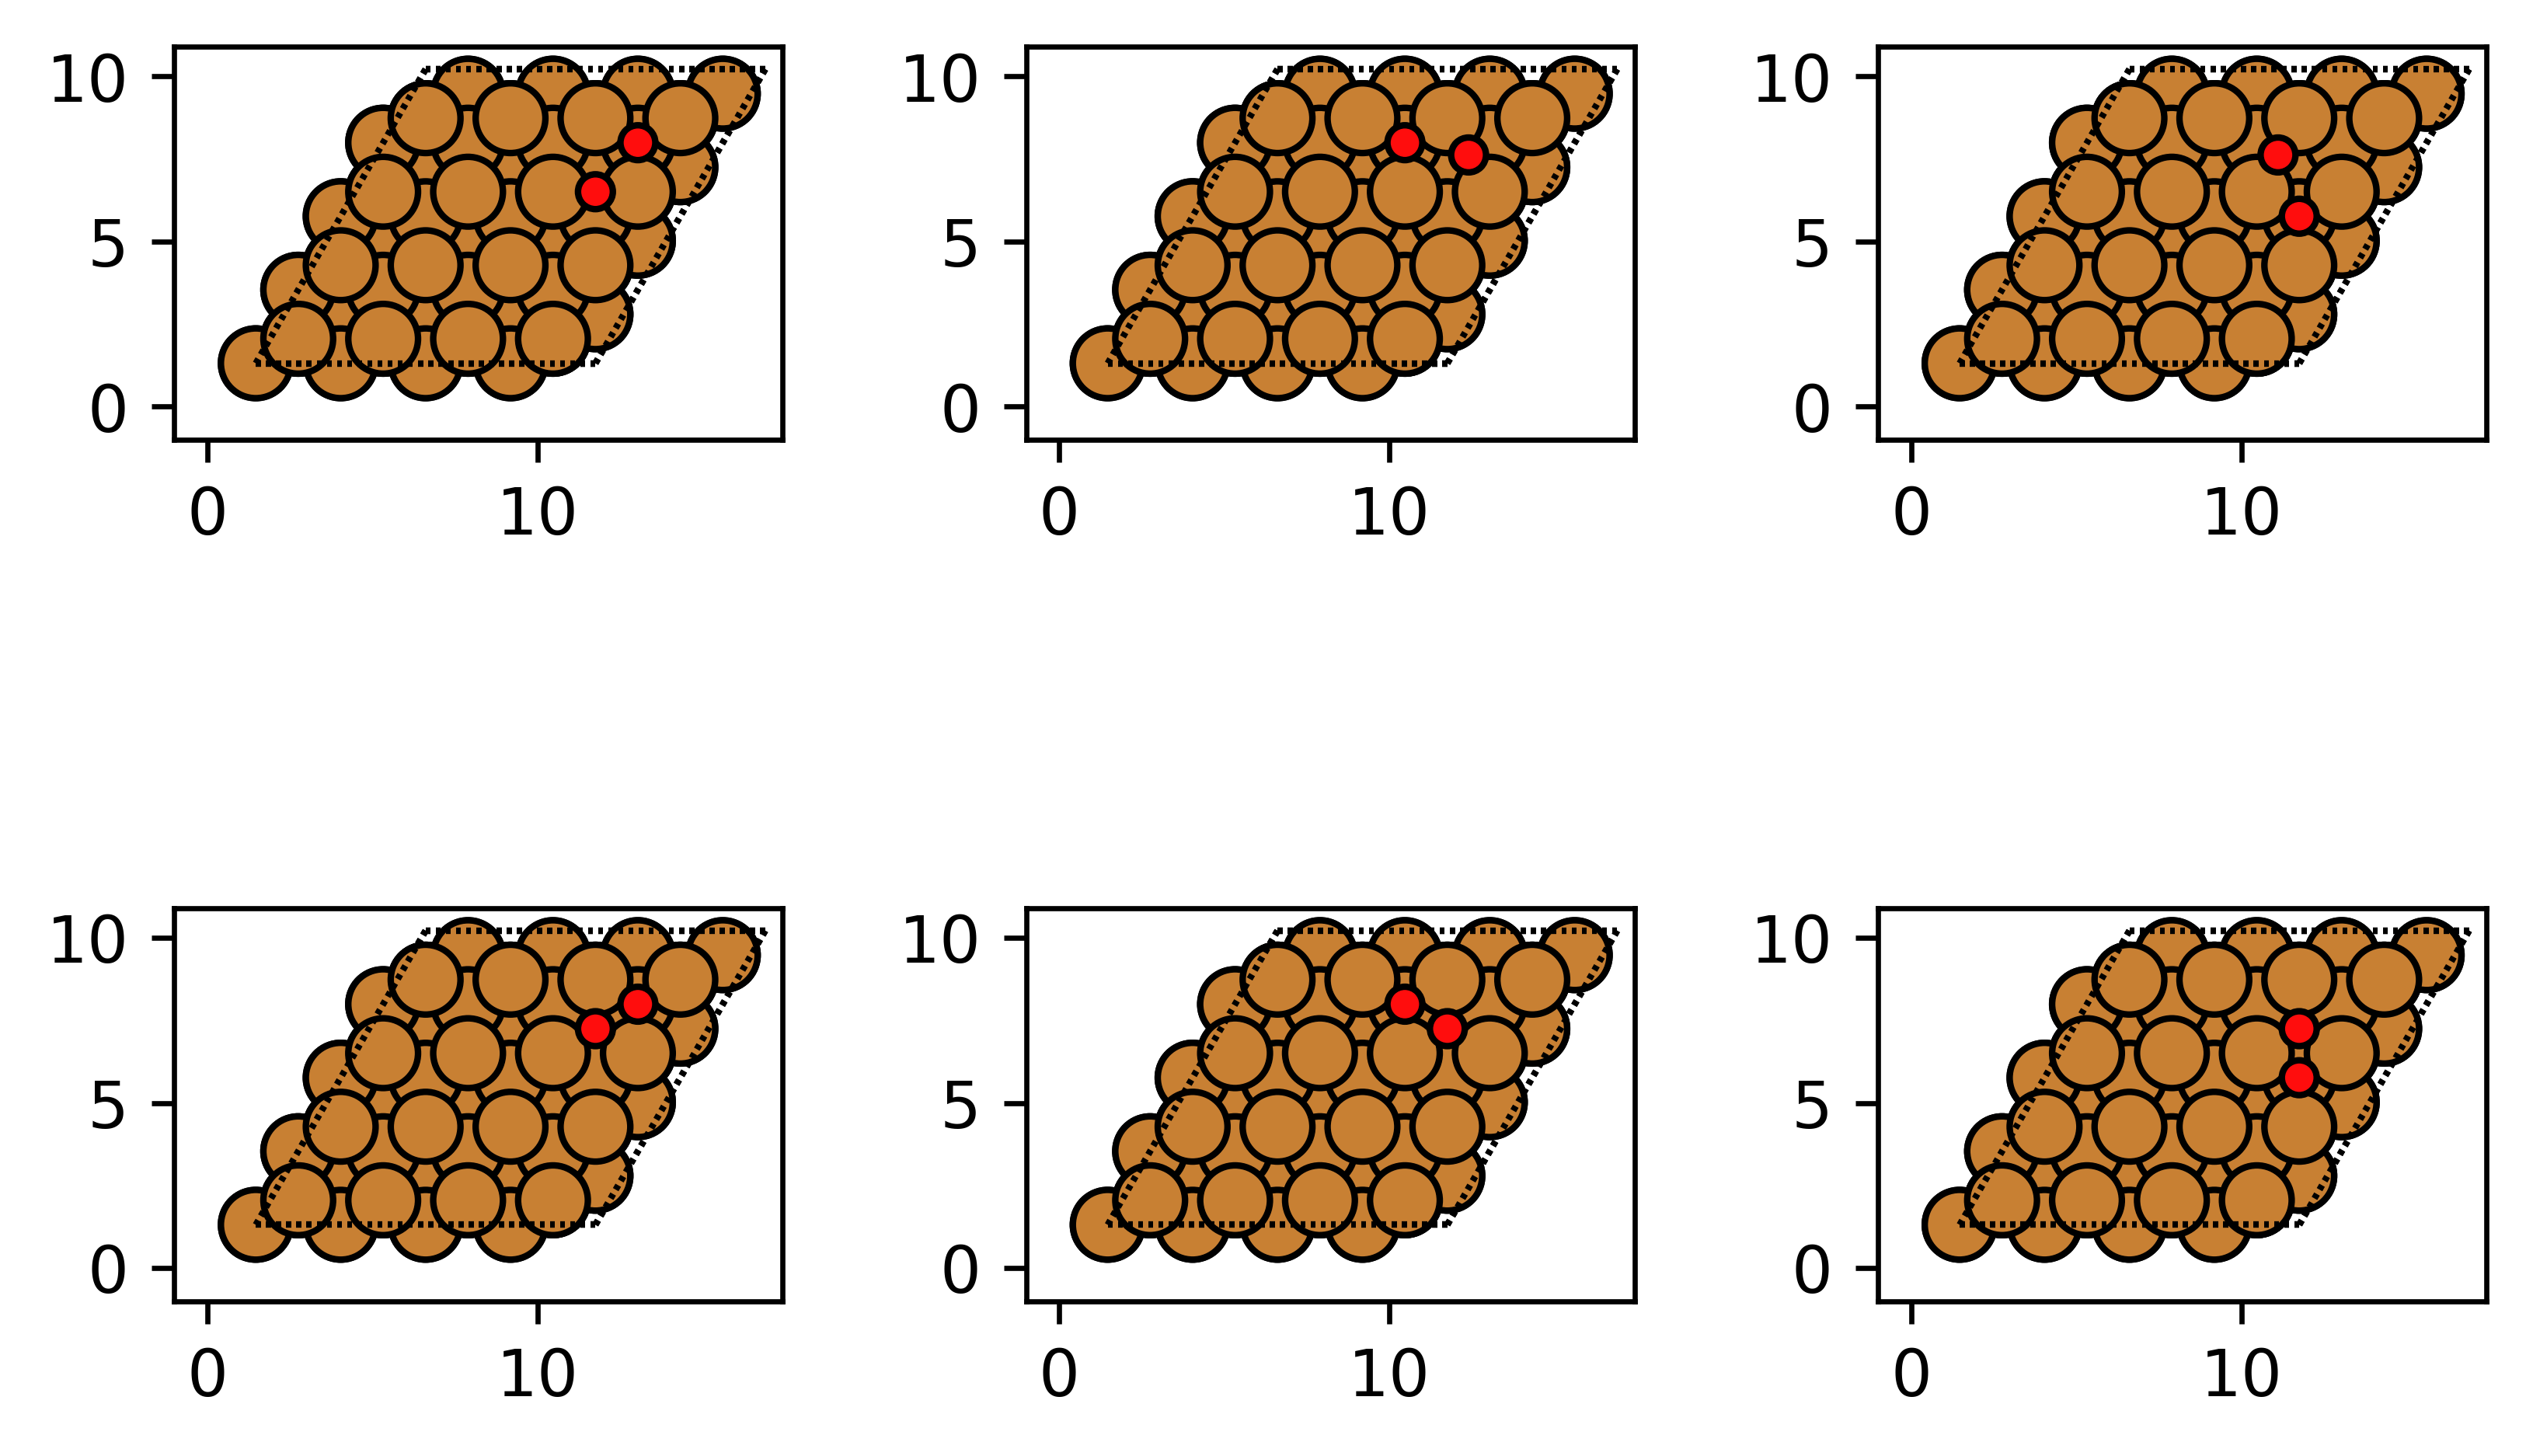

In [47]:
plot_top(mol_rotate_list, column=3)
# out_poscar(mol_rotate_dic, path="./vasp_cala/nostrain_molecule3")

# 5. Set strain
There should be four processes: 

① applying strain to the bulk, executing optimization; 

② cutting out the slab, executing optimization; 

③ adsorbing molecules, executing optimization

Firstly, there should be the results of the above process with a no strain slab as a reference

## 4.1 Strain free configuration reference

In [48]:
# directory = "./vasp_cala/refer_slab_cal/"
# strain_slabs_l, strain_slabs_d = read_cars(directory)  # 有应变的基底
mol_rotate_list = list(mol_rotate_dic.values())

需要构建吸附的（分子）两个原子和基底表面原子的对应关系。这个关系在 应变映射吸附分子初步推断起作用。

无应变吸附构型 和 有应变slab构型 推断 有应变吸附构型
可以认为与通道内的原子相关

In [49]:
def find_nearest_coordinate(aspos, spos):
    # 函数的作用是找到 adsatoms 中所有原子在slabatoms中的近邻原子
    # 将坐标数组转换为 NumPy 数组
    nei = []
    for i in range(len(aspos)):
        apos = aspos[i]
        distances = np.linalg.norm(apos - spos, axis=1)
        mdis = np.min(distances)
        indices = np.where(distances <= mdis + 1e-3)
        nei.append(indices[0])
    return nei


sort_nei = []  # 存储的是离吸附原子最近的基底原子
sort_nei_list = {}
for index, (key, adsalbi) in enumerate(mol_rotate_dic.items()):
    # adsalbi.set_constriant()
    rot = int(int(key.split("_")[-1]) / 120)
    print(rot)

    top1d = top3d[rot]
    adsi = adsalbi.get_positions()[-2:]
    fors = adsalbi[top3d[rot]].get_positions()
    rel = find_nearest_coordinate(adsi, fors)
    nei2 = []
    for j in rel:
        nei = [top1d[k] for k in j]
        nei2.append(nei)
    sort_nei.append(nei2)
    sort_nei_list[key] = nei2

0
1
2
0
1
2


In [50]:
sort_nei  # 每3个应该保持形式的一致

[[[83, 104, 111], [76, 104]],
 [[76, 83, 55], [83, 104]],
 [[76, 104, 97], [76, 83]],
 [[76, 83, 104], [83, 104, 111]],
 [[76, 83, 104], [76, 83, 55]],
 [[76, 83, 104], [76, 104, 97]]]

In [51]:
def plot_points(a, b):
    # 第一组点
    x1 = a[:, 0]
    y1 = a[:, 1]

    # 第二组点
    x2 = b[:, 0]
    y2 = b[:, 1]
    # 创建图形对象和子图对象
    fig, ax = plt.subplots()

    # 设置x和y轴等比例
    ax.set_aspect("equal")
    # 设置x轴和y轴范围
    ax.set_xlim([5, 15])
    ax.set_ylim([0, 10])
    # 绘制第一组点
    # 绘制第一组点
    ax.plot(x1, y1, "ro", markersize=15, label="Cu")
    # 绘制第二组点，使用空心圆圈
    ax.plot(x2, y2, "wo", mec="b", mew=2, label="O2")

    # 添加图例
    ax.legend()

    # 显示图形
    plt.show()

0


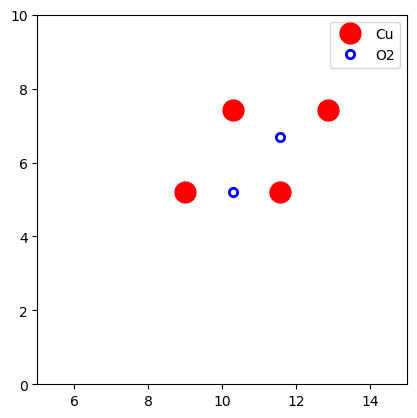

In [52]:
i = 0  # 校验通道和吸附原子的位置关系
keys = list(mol_rotate_dic.keys())
key = keys[i]
adsalbi = mol_rotate_dic[key]
# adsalbi.set_constriant()
rot = int(int(key.split("_")[-1]) / 120)
print(rot)

top1d = top3d[rot]
adsi = adsalbi.get_positions()[-2:]
fors = adsalbi[top3d[rot]].get_positions()
rel = find_nearest_coordinate(adsi, fors)
plot_points(fors[:, :2], adsi[:, :2])
nei2 = []
for j in rel:
    nei = [top1d[k] for k in j]
    nei2.append(nei)

In [53]:
strain_slabs_d0 = strain_slabs_d.copy()  # 不用copy会改变原本的变量
strain_slabs_d2 = {}  # 扩展的基底slab
strain_slabs_l2 = []

for i, (key0, value0) in enumerate(strain_slabs_d0.items()):
    ssd = {}
    ssl = []
    for j, (key, value) in enumerate(value0.items()):
        value_copy = value.copy()
        value_copy.set_constraint()
        value_copy = value_copy.repeat((4, 4, 1))
        ssd[key] = value_copy
        ssl.append(value_copy)
    strain_slabs_d2[key0] = ssd
    strain_slabs_l2.append(ssl)

strain_slabs_d2["1000"]["1000"]
strain_slabs_l2[0][0]

Atoms(symbols='Cu112', pbc=True, cell=[[9.97728282323322, 0.0, 0.0], [5.142929290326402, 8.907814830579476, 0.0], [0.0, 0.0, 30.0]])

In [54]:
strain_adslab = []
for i, (key, mol_refer) in enumerate(mol_rotate_dic.items()):  # 取出来一个无应变的吸附基底
    print(key)
    strain_slab_0 = strain_slabs_d2[str(i + 1000)]
    strain_adslabk = []
    for l in range(len(strain_slabs_l[0])):
        sslab_model = strain_slabs_d2[str(i + 1000)][str(l + 1000)]  # 取出来一个应变基底
        sslab_model = set_cons1(sslab_model)
        O2 = mol_refer[mol_refer.get_atomic_numbers() == 8]  # 提取其中的氧原子
        O2_pos = O2.get_positions()
        for j in range(len(O2)):  # 依据参考位置调整氧分子坐标
            pos_s = sslab_model[sort_nei[i][j]].get_positions()
            pos_s = np.mean(pos_s, axis=0)
            pos_m = mol_refer[sort_nei[i][j]].get_positions()
            pos_m = np.mean(pos_m, axis=0)
            pos_d = np.array(pos_s) - np.array(pos_m)
            O2_pos[j] += pos_d

        # 吸附氧分子
        O2 = Atoms("O2")
        O2.set_positions(O2_pos)
        sslab_model.extend(O2)
        # 设置自由度
        cons0 = sslab_model.constraints[0]
        cons1 = FixCartesian(
            [len(sslab_model) - 2, len(sslab_model) - 1], mask=(1, 1, 0)
        )
        sslab_model.set_constraint([cons0, cons1])  # 在之前约束基础上约束了两个
        strain_adslabk.append(sslab_model)
    strain_adslab.append(strain_adslabk)

top_0_hol_123_0
top_0_hol_123_120
top_0_hol_123_240
hol_123_bri_02_0
hol_123_bri_02_120
hol_123_bri_02_240


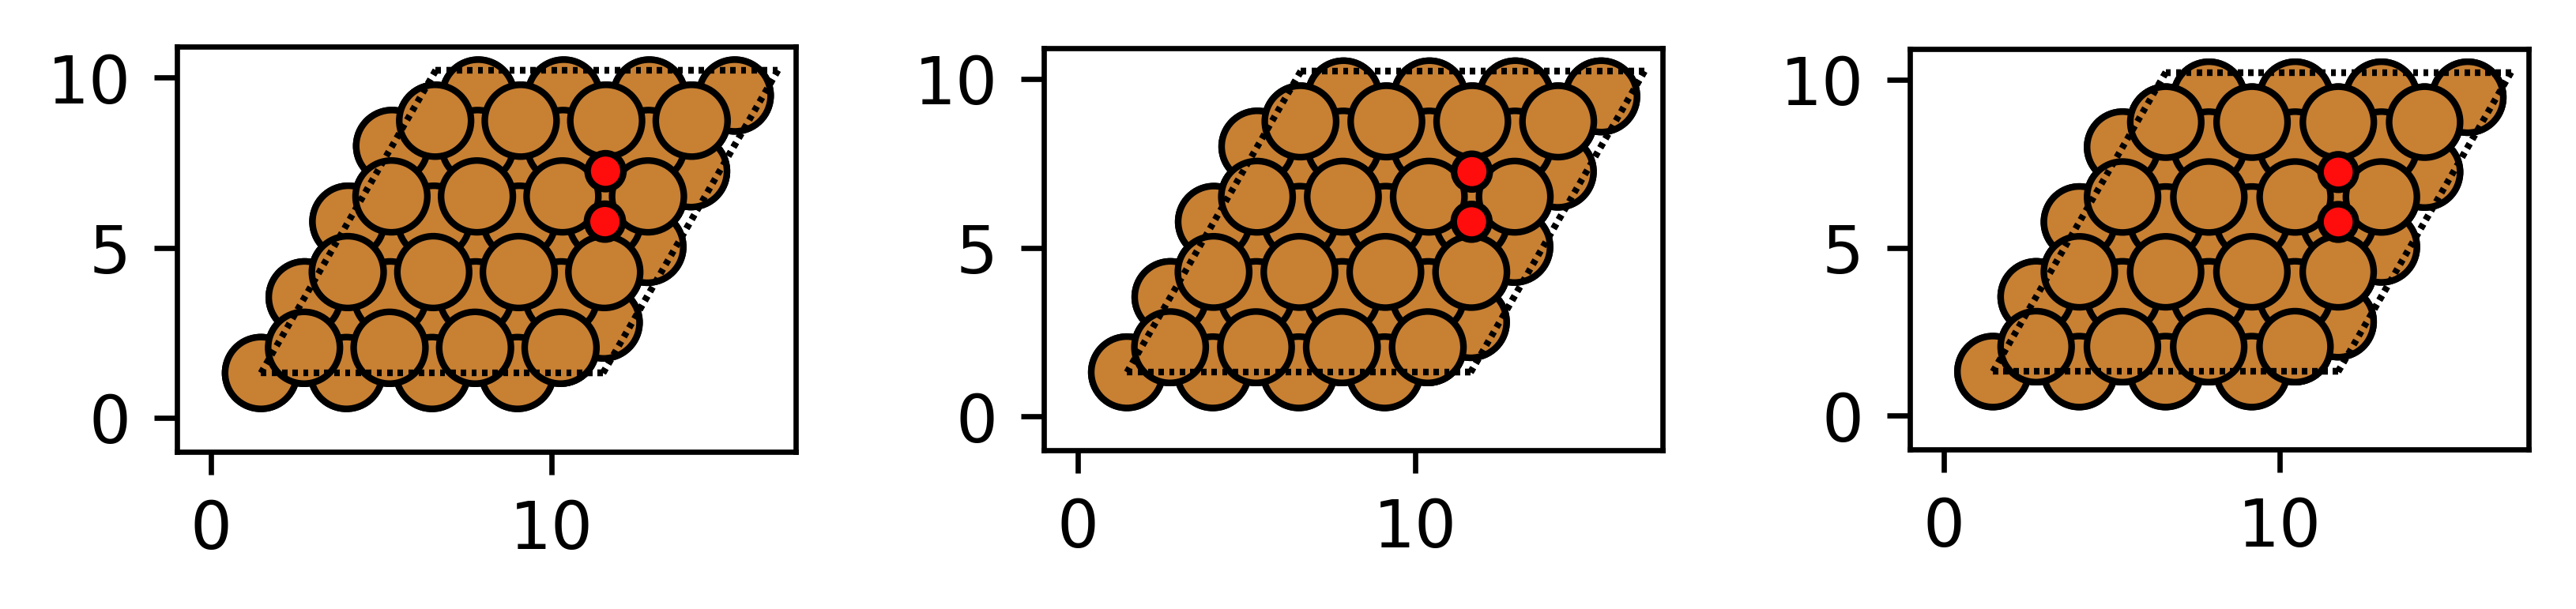

In [55]:
plot_top(strain_adslab[-1][:3])

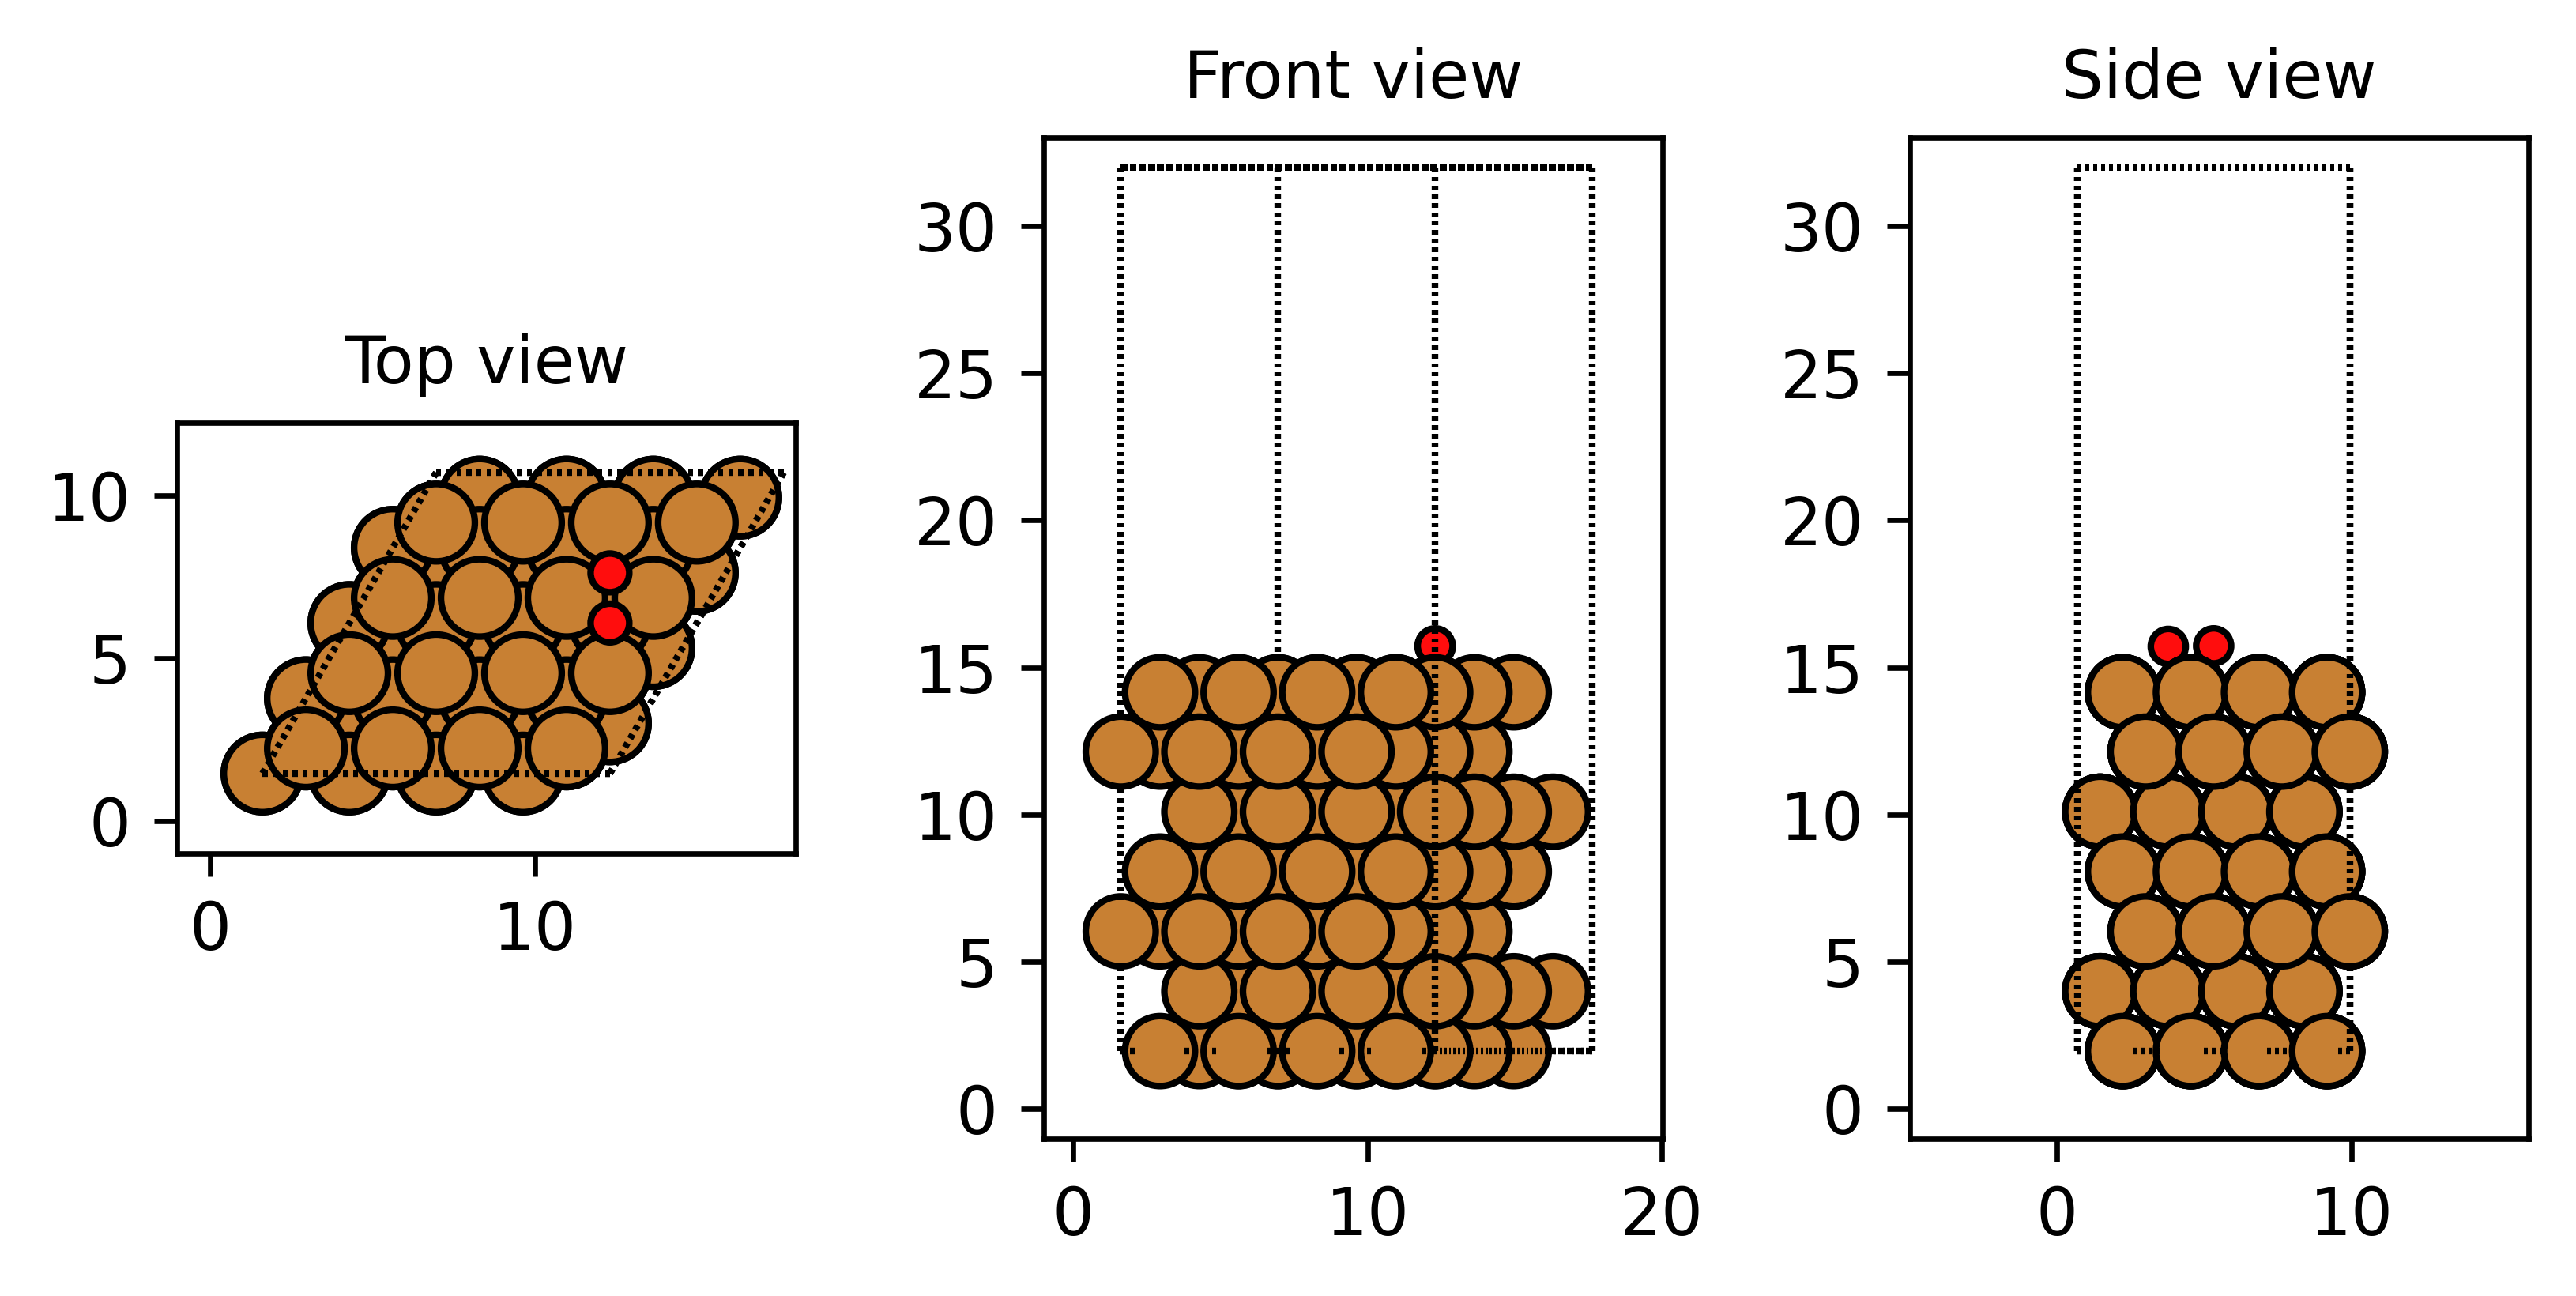

In [56]:
plot_model(strain_adslab[-1][-1])

In [57]:
out_car_list(strain_adslab, strain_adslab_folder)

input is list
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1000/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1001/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1002/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1003/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1004/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1005/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1006/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1007/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1008/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1009/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1010/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1011/POSCAR
write ------ /media/zwbai/DATA/dft/tc/output/strain_adslab/1000/1012/POSCA

# 6. Initial Structure to Relaxed Energy/Structure (IS2RE/IS2RS) LMDBs

IS2RE/IS2RS LMDBs utilize the SinglePointLmdb dataset. This dataset expects the data to be contained in a SINGLE LMDB file. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the IS2RE/IS2RS tasks:

- pos_relaxed: Relaxed adslab positions
- sid: Unique system identifier, arbitrary
- y_init: Initial adslab energy, formerly Data.y
- y_relaxed: Relaxed adslab energy
- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate


As a demo, we will use the above generated data to create an IS2R* LMDB file.

In [58]:
# 存储的是有应变的基底，乘以16倍就是等价的基底
# strain_slab_folder = "/media/zwbai/DATA/dft/shear/refer_slab_copy"
strain_slab_int = read_cars(refer_slab_copy, car="POSCAR")
strain_slab_opt = read_cars(refer_slab_copy, car="CONTCAR")
strain_slab_eng = read_cars(refer_slab_copy, car="OSZICAR")

/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1000/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1001/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1002/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1003/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1004/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1005/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1006/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1007/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1008/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1009/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1010/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1011/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1012/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1013/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_slab_copy/1000/1014/POSCAR
/media/zwbai/DATA/dft/tc/input/refer_sla

In [59]:
strain_slab_eng[0][0][2] * 16

-403.078816

In [60]:
# 存储的是有应变的吸附构型
# strain_adslab_folder = "/media/zwbai/DATA/dft/shear/strain_adslab_copy/"
strain_adslab_int = read_cars(strain_adslab_copy, car="POSCAR")
strain_adslab_opt = read_cars(strain_adslab_copy, car="CONTCAR")
strain_adslab_eng = read_cars(strain_adslab_copy, car="OSZICAR")
strain_adslab_ine = read_cars(strain_adslab_copy, car=["OSZICAR", 0])

/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1000/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1001/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1002/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1003/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1004/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1005/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1006/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1007/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1008/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1009/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1010/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1011/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1012/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1013/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1014/PO

/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1016/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1017/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1018/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1019/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1000/1020/POSCAR
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020'])
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1001/1000/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1001/1001/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1001/1002/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1001/1003/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1001/1004/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1001/1005/POSCAR
/media/zwbai/DATA/dft/tc/input/strain_adslab_copy/1001/1006/POSCAR
/media/zwbai

#### Initialize AtomsToGraph feature extractor

In [61]:
def read_trajectory_extract_features(a2g, traj):
    if isinstance(traj, list):
        tags = traj[0].get_tags()
        images = [traj[0], traj[-1]]
    elif isinstance(traj, Atoms):
        tags = traj.get_tags()
        images = [traj, traj]
    else:
        raise ValueError("traj must be list or Atoms")
    data_objects = a2g.convert_all(images, disable_tqdm=True)
    data_objects[0].tags = torch.LongTensor(tags)
    data_objects[1].tags = torch.LongTensor(tags)
    return data_objects

In [62]:
a2g = AtomsToGraphs(
    max_neigh=50,  # 设置每个原子最多与多少个相邻的原子建立联系。
    radius=6,  # 设置建立相邻原子之间边的最大距离。在此半径内的原子将被视为相邻原子。
    r_energy=True,  # False for test data 设置是否将能量作为节点特征添加到图中，默认为True，表示将能量添加到图中。
    r_forces=True,  # 设置是否将力作为节点特征添加到图中，默认为True，表示将力添加到图中。
    r_distances=False,  # 设置是否将原子之间的距离作为特征添加到图中，默认为False，表示不添加距离特征。
    r_fixed=True,  # 设置是否将固定性作为节点特征添加到图中，默认为True，表示将固定性添加到图中
)

In [63]:
def set_energy(model0, energy):
    model = model0.copy()
    model.set_calculator(EMT())
    # 假设已知能量为 energy_value
    energy_value = energy  # 假设能量值为10
    # 直接将能量赋值给 atoms 变量
    model.get_potential_energy()  # 先计算一次能量
    model.calc.results["energy"] = energy_value  # 修改势能值
    # 输出 atoms 的能量
    print(model.get_potential_energy())
    return model

In [64]:
def set_tags4adslab(adslab0):
    adslab = adslab0.copy()
    if not isinstance(adslab, Atoms):
        raise TypeError("Variable is not of atomic type")
    tags = np.zeros(len(adslab))
    layers = sort_z(adslab.get_positions()[:, 2])
    filtered_layers0 = [i for i in range(len(layers)) if layers[i] == 6]  # 被吸附基底的表面层
    tags[filtered_layers0] = 1  # 被吸附基底的表面层

    filtered_layers1 = [i for i in range(len(layers)) if layers[i] > 6]  # 被吸附基底的表面层
    tags[filtered_layers1] = 2  # 被吸附基底的表面层
    adslab.set_tags(tags)  # 将tags属性替换
    return adslab

In [65]:
sse = [item * 16 for row in strain_slab_eng[0] for item in row]  # 如此计算基底的能量
print(len(sse))
sse[0]

126


-402.616608

In [66]:
len(strain_slab_eng[0])

6

#### Initialize LMDB file

In [67]:
istore = True

In [68]:
"""
For most cases one just needs to change the name of the lmdb as they require.
Make sure to give the entire path in the config (with .lmdb) for IS2RE tasks
"""
# lmdb_file = "/media/zwbai/DATA/dft/shear/CuO2_strain_tc.lmdb"  # 重要的位置，存储了训练机器学习需要的样本
if istore:
    del_file(lmdb_file)
    del_file(f"{lmdb_file}-lock")

db = lmdb.open(
    lmdb_file,
    map_size=1024 * 1024 * 1024 * 2,
    subdir=False,
    meminit=False,
    map_async=True,
)

The file /media/zwbai/DATA/dft/tc/output/CuO2_strain_tc.lmdb was successfully deleted 
The file /media/zwbai/DATA/dft/tc/output/CuO2_strain_tc.lmdb-lock was successfully deleted 


In [69]:
E0_O2 = -0.98504822e01  # 02分子的能量
E0_O2

-9.8504822

In [70]:
if istore:
    idx = 0  # test
    for key, value in strain_adslab_opt[1].items():
        for key0, value0 in value.items():
            print(idx)

            # system1
            system_ads_rel = set_tags4adslab(value0)  # 松弛后的构型
            if not isinstance(system_ads_rel, Atoms):
                raise TypeError("Variable is not of atomic type")
            rel_e = strain_adslab_eng[1][key][key0]  # 对应的能量
            sse = strain_slab_eng[1][key][key0] * 4 * 4
            rel_e = rel_e - sse - E0_O2  # 吸附能
            system1 = set_energy(system_ads_rel, rel_e)

            # system0
            system_ads_int = set_tags4adslab(strain_adslab_int[1][key][key0])  # 松弛前的构型
            if not isinstance(system_ads_rel, Atoms):
                raise TypeError("Variable is not of atomic type")
            int_e = strain_adslab_ine[1][key][key0]  # 对应的能量
            int_e = int_e - sse - E0_O2  # 吸附能
            system0 = set_energy(system_ads_int, int_e)

            data_objects = read_trajectory_extract_features(a2g, [system0, system1])  #
            initial_struc = data_objects[0]
            relaxed_struc = data_objects[-1]

            initial_struc.y_init = (
                initial_struc.y
            )  # subtract off reference energy, if applicable
            del initial_struc.y
            initial_struc.y_relaxed = (
                relaxed_struc.y
            )  # subtract off reference energy, if applicable
            initial_struc.pos_relaxed = relaxed_struc.pos

            # Filter data if necessary
            # OCP filters adsorption energies > |10| eV

            initial_struc.sid = idx  # arbitrary unique identifier

            # no neighbor edge case check
            if initial_struc.edge_index.shape[1] == 0:
                print("no neighbors")
                continue

            # Write to LMDB
            txn = db.begin(write=True)
            txn.put(
                f"{idx}".encode("ascii"),
                pickle.dumps(initial_struc, protocol=-1),
            )
            txn.commit()
            db.sync()
            idx += 1

0


-0.4223898000000066
-0.20764980000000044
1


/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/pymatgen/io/ase.py:174: UserWarning: Only FixAtoms is supported by Pymatgen. Other constraints will not be set.
  warnings.warn("Only FixAtoms is supported by Pymatgen. Other constraints will not be set.")


-0.43804979999997506
-0.2257297999999981
2
-0.517391799999972
-0.30449179999998144
3
-0.6587377999999706
-0.4390277999999501
4
-0.8680418000000021
-0.6396018000000243
5
-1.008935800000005
-0.7635458000000188
6
-1.0755217999999775
-0.800281799999981
7
-0.37558979999998776
-0.14334979999999753
8
-0.4006578000000207
-0.18485780000001917
9
-0.4945658000000197
-0.28040580000002713
10
-0.6587377999999706
-0.4390277999999501
11
-0.8848657999999876
-0.6604958000000227
12
-1.0365378000000067
-0.7915478000000338
13
-1.1159117999999797
-0.8611218000000225
14
0.006646200000046676
0.2469762000000184
15
-0.08917979999999837
0.13437019999999045
16
-0.32488380000005357
-0.10216380000001557
17
-0.6587377999999706
-0.4390277999999501
18
-1.0613317999999925
-0.8235117999999932
19
-1.3050337999999773
-1.0337837999999682
20
-1.4761018000000252
-1.1612618000000214
21
-0.3364577999999927
-0.11997780000000269
22
-0.386679800000012
-0.17529979999999235
23
-0.5035097999999483
-0.28988979999995657
24
-0.69685579

In [71]:
print("lmdb file path:", lmdb_file)
train_dataset = LmdbDataset({"src": lmdb_file})

energies = [data.y_relaxed for data in train_dataset]
mean = np.mean(energies)
stdev = np.std(energies)
mean, stdev, len(energies)

lmdb file path: /media/zwbai/DATA/dft/tc/output/CuO2_strain_tc.lmdb


(-0.43024899047618376, 0.4674836546085526, 126)

# 7. build DOS dataset 

In [73]:
# dos_cal_folder = "/media/zwbai/DATA/dft/shear/dos_cal/"
dos_l, dos_d = read_cars(dos_cal, car="DOSCAR")
# directory = "./vasp_cala/refer_slab_cal/"
# edos_l, edos_d = read_cars(dos_cal_folder,car='DOSCAR')

/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1000/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1001/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1002/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1003/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1004/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1005/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1006/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1007/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1008/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1009/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1010/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1011/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1012/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1013/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1014/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1015/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1016/DOSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1017

In [74]:
atomdos_l, atomdos_d = read_cars(dos_cal, car="POSCAR")

/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1000/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1001/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1002/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1003/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1004/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1005/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1006/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1007/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1008/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1009/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1010/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1011/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1012/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1013/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1014/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1015/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1016/POSCAR
/media/zwbai/DATA/dft/tc/input/dos_cal/1000/1017

In [75]:
lenth = len(atomdos_l[0])
for i in range(len(atomdos_l)):
    for j in range(len(atomdos_l[0])):
        print(i * lenth + j)
        print(train_dataset[i * lenth + j].cell)
        print(4 * atomdos_l[i][j].cell)

0
tensor([[[ 9.9773,  0.0000,  0.0000],
         [ 5.1429,  8.9078,  0.0000],
         [ 0.0000,  0.0000, 30.0000]]])
[[  9.9773   0.       0.    ]
 [  5.1429   8.9078   0.    ]
 [  0.       0.     120.    ]]
1
tensor([[[10.0801,  0.0000,  0.0000],
         [ 5.1429,  8.9078,  0.0000],
         [ 0.0000,  0.0000, 30.0000]]])
[[ 10.0801   0.       0.    ]
 [  5.1429   8.9078   0.    ]
 [  0.       0.     120.    ]]
2
tensor([[[10.1830,  0.0000,  0.0000],
         [ 5.1429,  8.9078,  0.0000],
         [ 0.0000,  0.0000, 30.0000]]])
[[ 10.183    0.       0.    ]
 [  5.1429   8.9078   0.    ]
 [  0.       0.     120.    ]]
3
tensor([[[10.2859,  0.0000,  0.0000],
         [ 5.1429,  8.9078,  0.0000],
         [ 0.0000,  0.0000, 30.0000]]])
[[ 10.2859   0.       0.    ]
 [  5.1429   8.9078   0.    ]
 [  0.       0.     120.    ]]
4
tensor([[[10.3887,  0.0000,  0.0000],
         [ 5.1429,  8.9078,  0.0000],
         [ 0.0000,  0.0000, 30.0000]]])
[[ 10.3887   0.       0.    ]
 [  5.1429   8.9

In [76]:
for i in range(len(atomdos_l)):
    print(i)
    for j in range(len(atomdos_l[0])):
        print(j)
        cal_strain(atomdos_l[i][j], strain_slabs_l[i][j])

0
0
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
1
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2
strain: 
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
3
strain: 
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
4
strain: 
 [[-0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
5
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
6
strain: 
 [[ 0. -0.  0.]
 [-0.  0.  0.]
 [ 0.  0.  0.]]
7
strain: 
 [[ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0. -0.]]
8
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
9
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
10
strain: 
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
11
strain: 
 [[ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]]
12
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
13
strain: 
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
14
strain: 
 [[ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0.  0.]]
15
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
16
strain: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
17
strain: 
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
18
strain: 
 [[-0.

In [77]:
lenth = len(dos_l[0])
shape_dos_l0 = dos_l[0][0].shape
dos_data = np.zeros((len(dos_l) * len(dos_l[0]), shape_dos_l0[0], shape_dos_l0[1]))

for i in range(len(dos_l)):
    for j in range(len(dos_l[0])):
        k = i * lenth + j

        dos_data[k] = dos_l[i][j]
dos_data.shape

(126, 1600, 10)

In [78]:
targets = np.array(energies)
targets.shape

(126,)

In [79]:
print(dos_data.shape)
with open(dos_data_file, mode="wb") as f:
    pickle.dump(dos_data, f)
    pickle.dump(targets, f)

(126, 1600, 10)


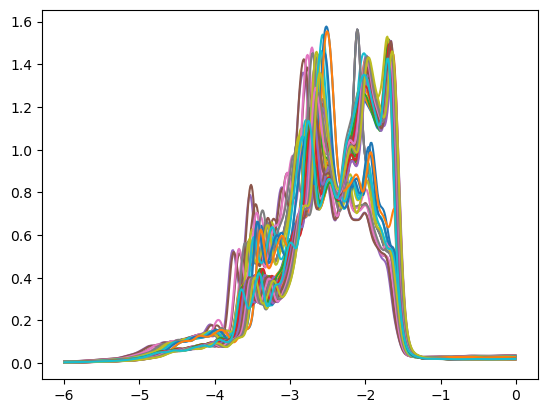

In [80]:
for i in range(0, 50):
    plt.plot(dos_data[j, 200:800, 0], dos_data[i, 200:800, 8])
plt.show()

# 8. Creat Dos Set

## 8.1 Function

In [81]:
def point_position(line_point1, line_point2, point3):
    # 计算
    if line_point1[0] == line_point2[0]:
        # 处理直线垂直于x轴的情况
        return point3[0] != line_point1[0]
    else:
        # 计算直线的斜率
        slope = (line_point2[1] - line_point1[1]) / (line_point2[0] - line_point1[0])

        # 计算第三个点的纵坐标
        y3 = line_point1[1] + slope * (point3[0] - line_point1[0])

        return point3[1] > y3


# 示例数据
line_point1 = (1, 1)
line_point2 = (5, 5)
point3 = (3, 2)

position = "上方" if point_position(line_point1, line_point2, point3) else "下方"
print(f"第三个点在直线的{position}")

第三个点在直线的下方


In [82]:
def atom2graph(atom, dos, threshold=2.8):
    import scipy.sparse as sp
    import pandas as pd

    pos = atom.pos
    cell = atom.cell
    anum = np.array([int(n) for n in atom.atomic_numbers])

    tri = [
        point_position(cell[0][0], cell[0][1], posi[:2])
        and posi[2] > min(sorted(pos[:, 2] - 0.01, reverse=True)[:18])
        for posi in pos
    ]
    coordinates = np.array(pos[tri])
    anum = np.array(anum[tri])

    # 计算原子之间的距离矩阵
    distances = sp_distance.squareform(sp_distance.pdist(coordinates))
    # 创建连接矩阵
    adjacency = np.zeros((len(coordinates), len(coordinates)), dtype=np.float32)

    if type(threshold) is pd.DataFrame:
        for i in range(len(adjacency)):
            for j in range(len(adjacency)):
                cut = threshold[anum[i]][anum[j]]
                adjacency[i, j] = 1 if distances[i, j] < cut else 0  # 标记成键
    else:
        adjacency[distances <= threshold] = 1

    np.fill_diagonal(adjacency, 0)

    # 创建节点特征矩阵（可选)
    dos1 = dos.reshape((1, -1))
    dos0 = np.zeros(dos1.shape)
    dos8 = np.zeros((len(anum), dos1.shape[1]))
    dos8[anum == 8] = dos0
    dos8[anum == 29] = dos1
    node_features = dos8

    # 创建边特征矩阵（可选)
    adj = adjacency.copy()  # 边属性矩阵，来自于链接矩阵
    for i in range(len(anum)):
        if anum[i] == 8:
            for j in range(len(anum)):
                if anum[j] == 8:
                    adj[i, j] = 0  # 不考虑O-O键
    for i in range(len(anum)):
        if anum[i] == 8:
            adj[i, i] = sum(adj[i, :]) + 1  # 计算氧成键
    for i in range(len(anum)):
        if anum[i] != 8:
            for j in range(len(anum)):
                if anum[j] == 8 and adj[i, j] == 1:
                    adj[i, j] = adj[j, j]  # 计算氧成键，1已经分配
    for i in range(len(anum)):
        for j in range(i + 1, len(anum)):
            adj[j][i] = adj[i][j]

    n_edge = int(sum(sum(adjacency)))  # 注意 使用的链接矩阵
    n_edge_features = 4  # 假设每条边有3个属性值
    edges = np.argwhere(adjacency)  # edges包含了所有非零边的坐标
    edge_features = np.zeros((n_edge, n_edge_features))  # 创建一个空的边特征矩阵
    for i, (r, c) in enumerate(edges):
        att = int(max(adjacency[r, c], adj[r, c])) - 1  # 链接矩阵和边属性矩阵的最大值
        if att > 3:
            print(att)
            att = 3
        edge_features[i][att] = 1  # 注意要将属性值从1开始编号转换为从0开始编号

    # 创建标签（可选）
    labels = atom.y_relaxed

    adj_sparse = sp.coo_matrix(adjacency)

    # 创建Graph对象
    graph = Graph(x=node_features, a=adj_sparse, e=edge_features, y=labels)
    return graph

## 8.2 strain model and dos data

In [83]:
# lmdb_file = "/media/zwbai/DATA/dft/new_Cu_tc/CuO2_strain_tc.lmdb"  # 重要的位置，存储了训练机器学习需要的构型样本和吸附能
print("lmdb file path:", lmdb_file)
train_dataset = LmdbDataset({"src": lmdb_file})

energies = [data.y_relaxed for data in train_dataset]
mean = np.mean(energies)
stdev = np.std(energies)
mean, stdev, len(energies)

lmdb file path: /media/zwbai/DATA/dft/tc/output/CuO2_strain_tc.lmdb


(-0.43024899047618376, 0.4674836546085526, 126)

In [84]:
train_dataset[0]

Data(pos=[114, 3], cell=[1, 3, 3], atomic_numbers=[114], natoms=114, tags=[114], edge_index=[2, 5549], cell_offsets=[5549, 3], force=[114, 3], fixed=[114], y_init=-0.20764980000000044, y_relaxed=-0.4223898000000066, pos_relaxed=[114, 3], sid=0)

In [85]:
train_dataset[0].atomic_numbers

tensor([29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
        29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
         8.,  8.])

In [86]:
train_dataset[0].y_relaxed

-0.4223898000000066

In [87]:
with open(dos_data_file, mode="rb") as f:
    surface_dos_data = pickle.load(f)
    targets = pickle.load(f)

In [88]:
surface_dos_data.shape, targets.shape

((126, 1600, 10), (126,))

In [89]:
dosdata = surface_dos_data[:, 300:700, 4:10]
dosdata[:, :, 0] = surface_dos_data[:, 300:700, 0]
dosdata.shape

(126, 400, 6)

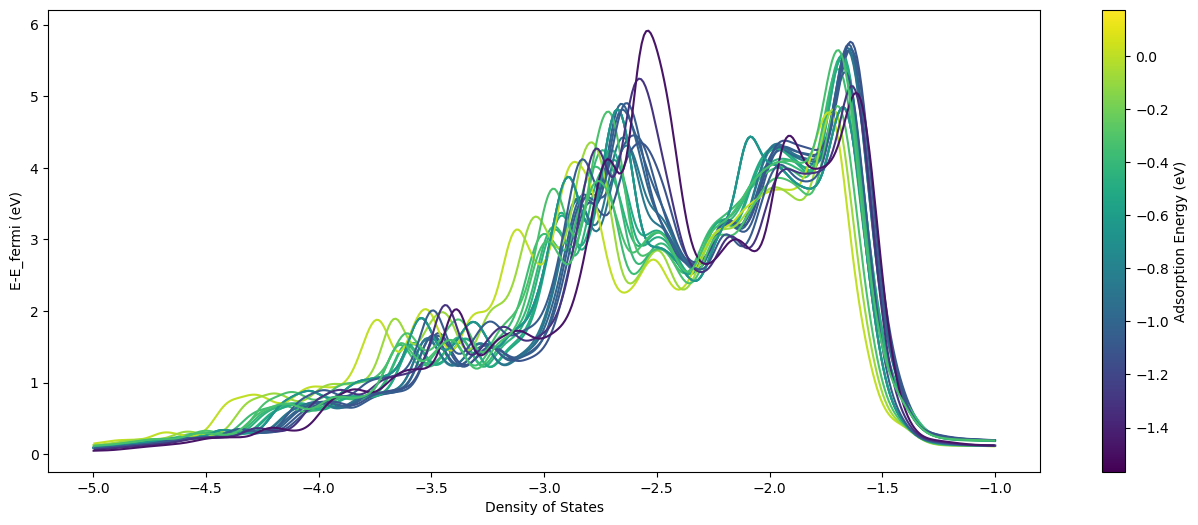

In [90]:
# 创建彩虹图的 colormap
cmap = plt.get_cmap("rainbow")

z = energies[:66]
# 创建彩虹图的 colormap
cmap = plt.get_cmap("viridis")

# 设置合适的数值范围
vmin = np.min(z)
vmax = np.max(z)

fig, ax = plt.subplots(figsize=(16, 6))

for i in range(1, 22):
    # color = cmap(z[i])
    color = cmap((z[i] - vmin) / (vmax - vmin))
    # color = cmap(energies[i])  # 根据 z 的值获取对应的颜色
    ax.plot(dosdata[i, :, 0], np.sum(dosdata[i, :, 1:5], axis=1), color=color)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # 设置一个空数组，传递给 colorbar
cbar = plt.colorbar(sm, ax=ax)

# 添加标签
ax.set_xlabel("Density of States")
ax.set_ylabel("E-E_fermi (eV)")
cbar.set_label("Adsorption Energy (eV)")

plt.show()

# 8.3 Dataset

In [91]:
row_index = [8, 29]
matrix_zeros = np.zeros([len(row_index), len(row_index)])
columns_index = row_index
table = pd.DataFrame(matrix_zeros, columns=columns_index, index=row_index)
table[:][:] = 2.0
table[29][29] = 2.8
print(table)

     8    29
8   2.0  2.0
29  2.0  2.8


In [92]:
g = atom2graph(train_dataset[66], dosdata[0][:, 1:], threshold=table)
g

Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1)

In [93]:
channel = 5
d = dosdata[0][:, 1:].reshape((1, -1))
d0 = d.reshape(channel, -1).T
d0.shape

(400, 5)

In [94]:
graph_data = []
for i in range(len(train_dataset)):
    g = atom2graph(train_dataset[i], dosdata[i][:, 1:], threshold=table)
    graph_data.append(g)

In [95]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [96]:
GraphDataset = MyGraphDataset(graph_data)
GraphDataset[0]

Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1)

In [97]:
GraphDataset.graphs

[Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_lab

In [98]:
# 存储数据到文件
with open(dos_energy_data_file, "wb") as file:
    pickle.dump(GraphDataset, file)

In [99]:
# 从文件中提取数据
with open(dos_energy_data_file, "rb") as file:
    loaded_data = pickle.load(file)

print(loaded_data)  # 输出：[1, 2, 3, 4, 5]
loaded_data[0]

MyGraphDataset(n_graphs=126)


Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1)

In [100]:
exist_folder(data_path, is_creat=True)
for file in data_files:
    shutil.copy(file, data_path) # copy file for further ML